In [1]:
import pythetatools.toyxp as toyxp
import pythetatools.likelihood as likelihood
from pythetatools.global_names import *
from pythetatools.base_visualisation import *
from pythetatools.file_manager import read_histogram, download
from pythetatools.base_analysis import critical_value_for_cl
from pythetatools.critical_values_FC import *

from collections import defaultdict
import shutil
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import uproot
import matplotlib.colors as colors
from matplotlib.ticker import LogLocator, NullFormatter
import pandas as pd

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.style.use(t2k_style)

Welcome to JupyROOT 6.28/04


In [2]:
%load_ext autoreload
%autoreload 2

In [13]:
param_name = 'delta'
true_mh = 1
postfix = {'delta':'_23', 'sin223':'_Sin223_23_new'}
suffix = {'delta':'', 'sin223':'sin223'}

# Download if necessary

In [5]:
for param_value in param_values_FC[param_name]:
    basename_directory = f"MargTemplates_LucileThesis_fit_FC{suffix[param_name]}_{param_value}_{true_mh}_FullSyst_wRC_etheta_ptheta_{param_name}"

    input_path = f"/sps/t2k/Archive_OA2023_ToKeep/FC/output_FC{postfix[param_name]}/{basename_directory}/MergeToyMargTemplates"
    dir_ver = 'OA2023'
    patern = '*.root'
    destination = f"{inputs_dir}/{dir_ver}/FC/{basename_directory}"

    download(input_path, destination, new_name='', pattern=patern, login=my_login, domain=my_domain, overwrite=False)

directory
Destination folder already exists: /Users/denis.carabadjac/Python/pythetatools/inputs/OA2023/FC/MargTemplates_LucileThesis_fit_FC_0.0_1_FullSyst_wRC_etheta_ptheta_delta
Executing: rsync -ah --progress --include='*.root' --exclude='*' dcarabad@cca.in2p3.fr:/sps/t2k/Archive_OA2023_ToKeep/FC/output_FC_23/MargTemplates_LucileThesis_fit_FC_0.0_1_FullSyst_wRC_etheta_ptheta_delta/MergeToyMargTemplates/ /Users/denis.carabadjac/Python/pythetatools/inputs/OA2023/FC/MargTemplates_LucileThesis_fit_FC_0.0_1_FullSyst_wRC_etheta_ptheta_delta/
directory
Destination folder already exists: /Users/denis.carabadjac/Python/pythetatools/inputs/OA2023/FC/MargTemplates_LucileThesis_fit_FC_0.392699081699_1_FullSyst_wRC_etheta_ptheta_delta
Executing: rsync -ah --progress --include='*.root' --exclude='*' dcarabad@cca.in2p3.fr:/sps/t2k/Archive_OA2023_ToKeep/FC/output_FC_23/MargTemplates_LucileThesis_fit_FC_0.392699081699_1_FullSyst_wRC_etheta_ptheta_delta/MergeToyMargTemplates/ /Users/denis.carabadjac/P

# Plot dchi2 distributions. Write critical values in ROOT and np files

In [17]:
def plot_dchi2_distr(grid_x, dchi2, param_name_x, true_param, true_mh, levels, crit_val_centrals, outputs_dir, dir_ver):

    fig, ax = plt.subplots()
    ax.hist(dchi2, bins=20, color=color_mo[true_mh], zorder=0)
    for level, crit_val_central in zip(levels, crit_val_centrals):
        ax.axvline(crit_val_central, color='black', ls=level_to_ls[level], label=level_to_label[level]+r' $\Delta \chi^2_{c}$='+f'{round(crit_val_central, 2)}')

    ax.set_title('True ' +osc_param_title[param_name_x][0]+f' = {round(true_param, 2)}; True {mo_to_title[true_mh]}', loc='right')
    ax.set_xlabel("$\Delta \chi^2$")
    ax.set_xlim(0, 20)
    show_minor_ticks(ax)
    ax.legend(framealpha=0)
    fig.savefig(f'{outputs_dir}/plots/{dir_ver}/FC/FC_dchi2_distr_{param_name_x}_{true_param}_truemh{true_mh}.pdf', bbox_inches='tight')
    

Number of entries in 'MargTemplate': 5100000.
Grid sizes: [51] for parameters ['delta']
Number of entries in 'MargTemplate': 5100000.
Grid sizes: [51] for parameters ['delta']
Number of entries in 'MargTemplate': 5100000.
Grid sizes: [51] for parameters ['delta']
Number of entries in 'MargTemplate': 5100000.
Grid sizes: [51] for parameters ['delta']
Number of entries in 'MargTemplate': 5100000.
Grid sizes: [51] for parameters ['delta']
Number of entries in 'MargTemplate': 5100000.
Grid sizes: [51] for parameters ['delta']
Number of entries in 'MargTemplate': 5100000.
Grid sizes: [51] for parameters ['delta']
Number of entries in 'MargTemplate': 5100000.
Grid sizes: [51] for parameters ['delta']
Number of entries in 'MargTemplate': 5100000.
Grid sizes: [51] for parameters ['delta']
Number of entries in 'MargTemplate': 5100000.
Grid sizes: [51] for parameters ['delta']
Number of entries in 'MargTemplate': 5100000.
Grid sizes: [51] for parameters ['delta']
Number of entries in 'MargTempla

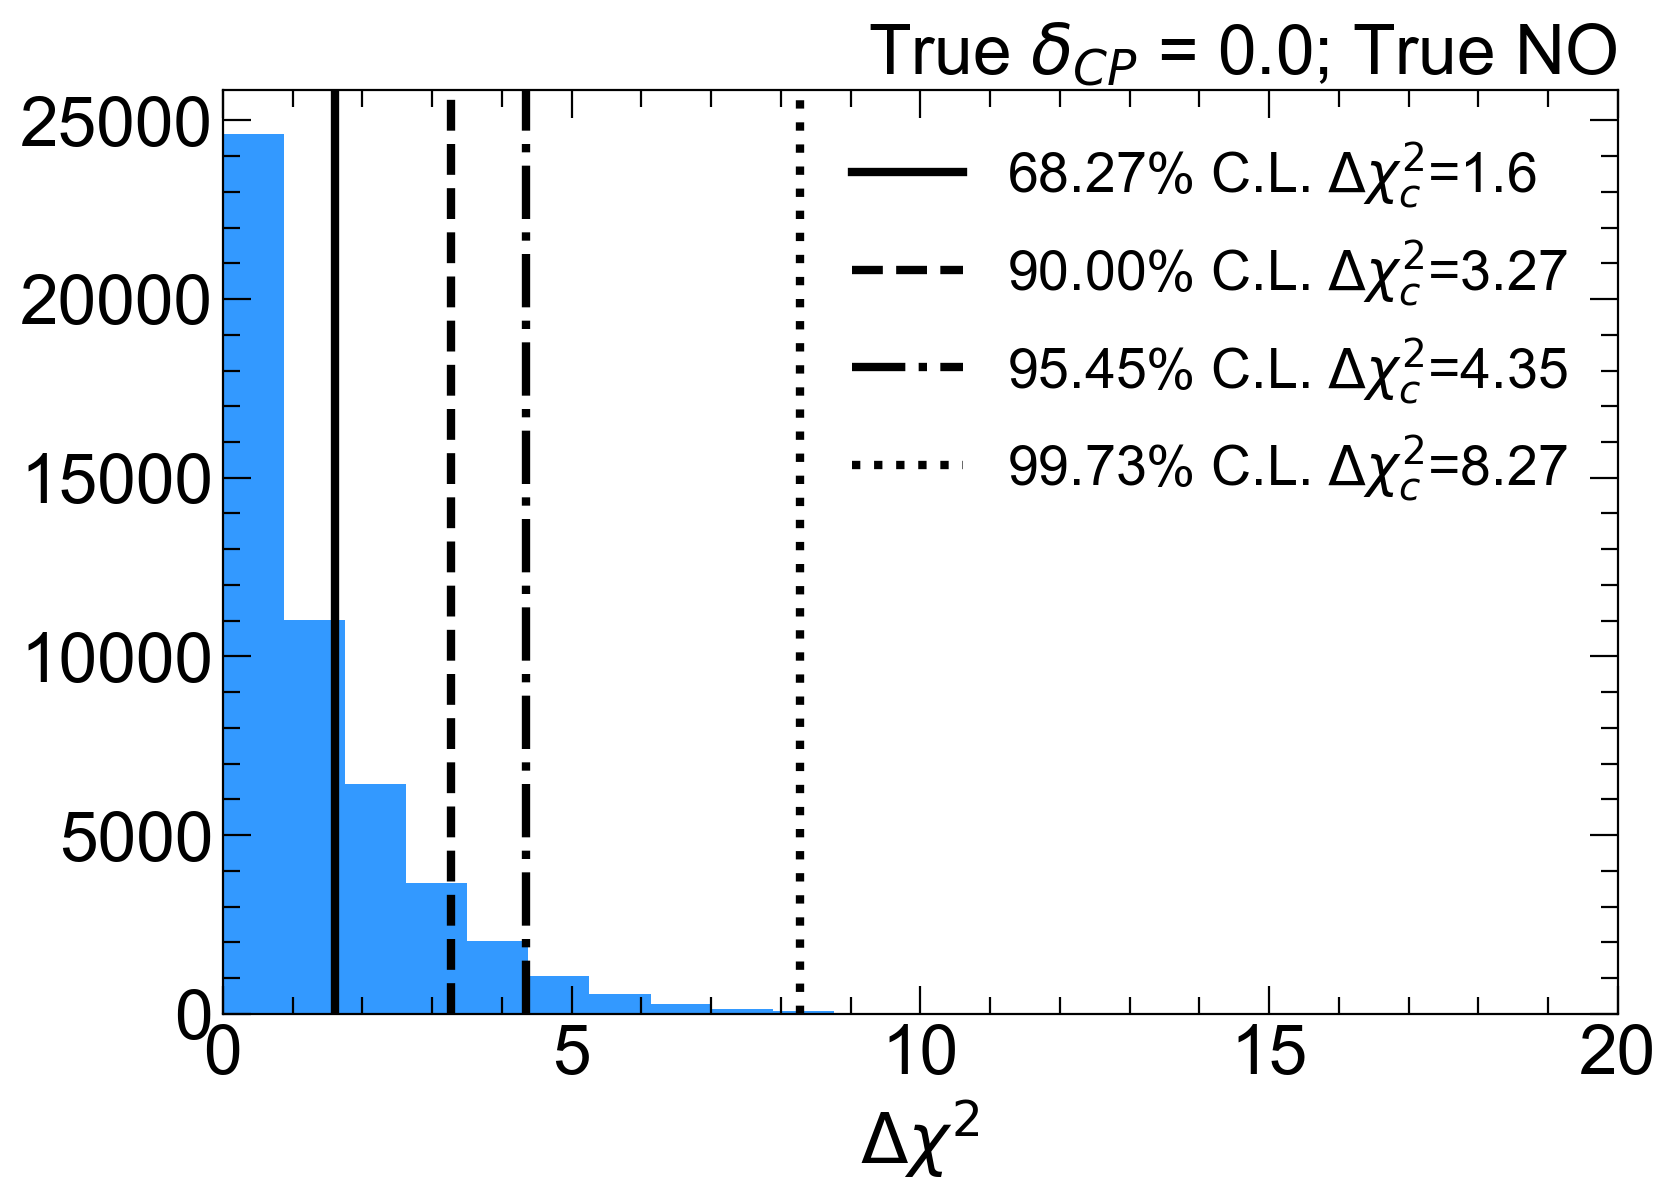

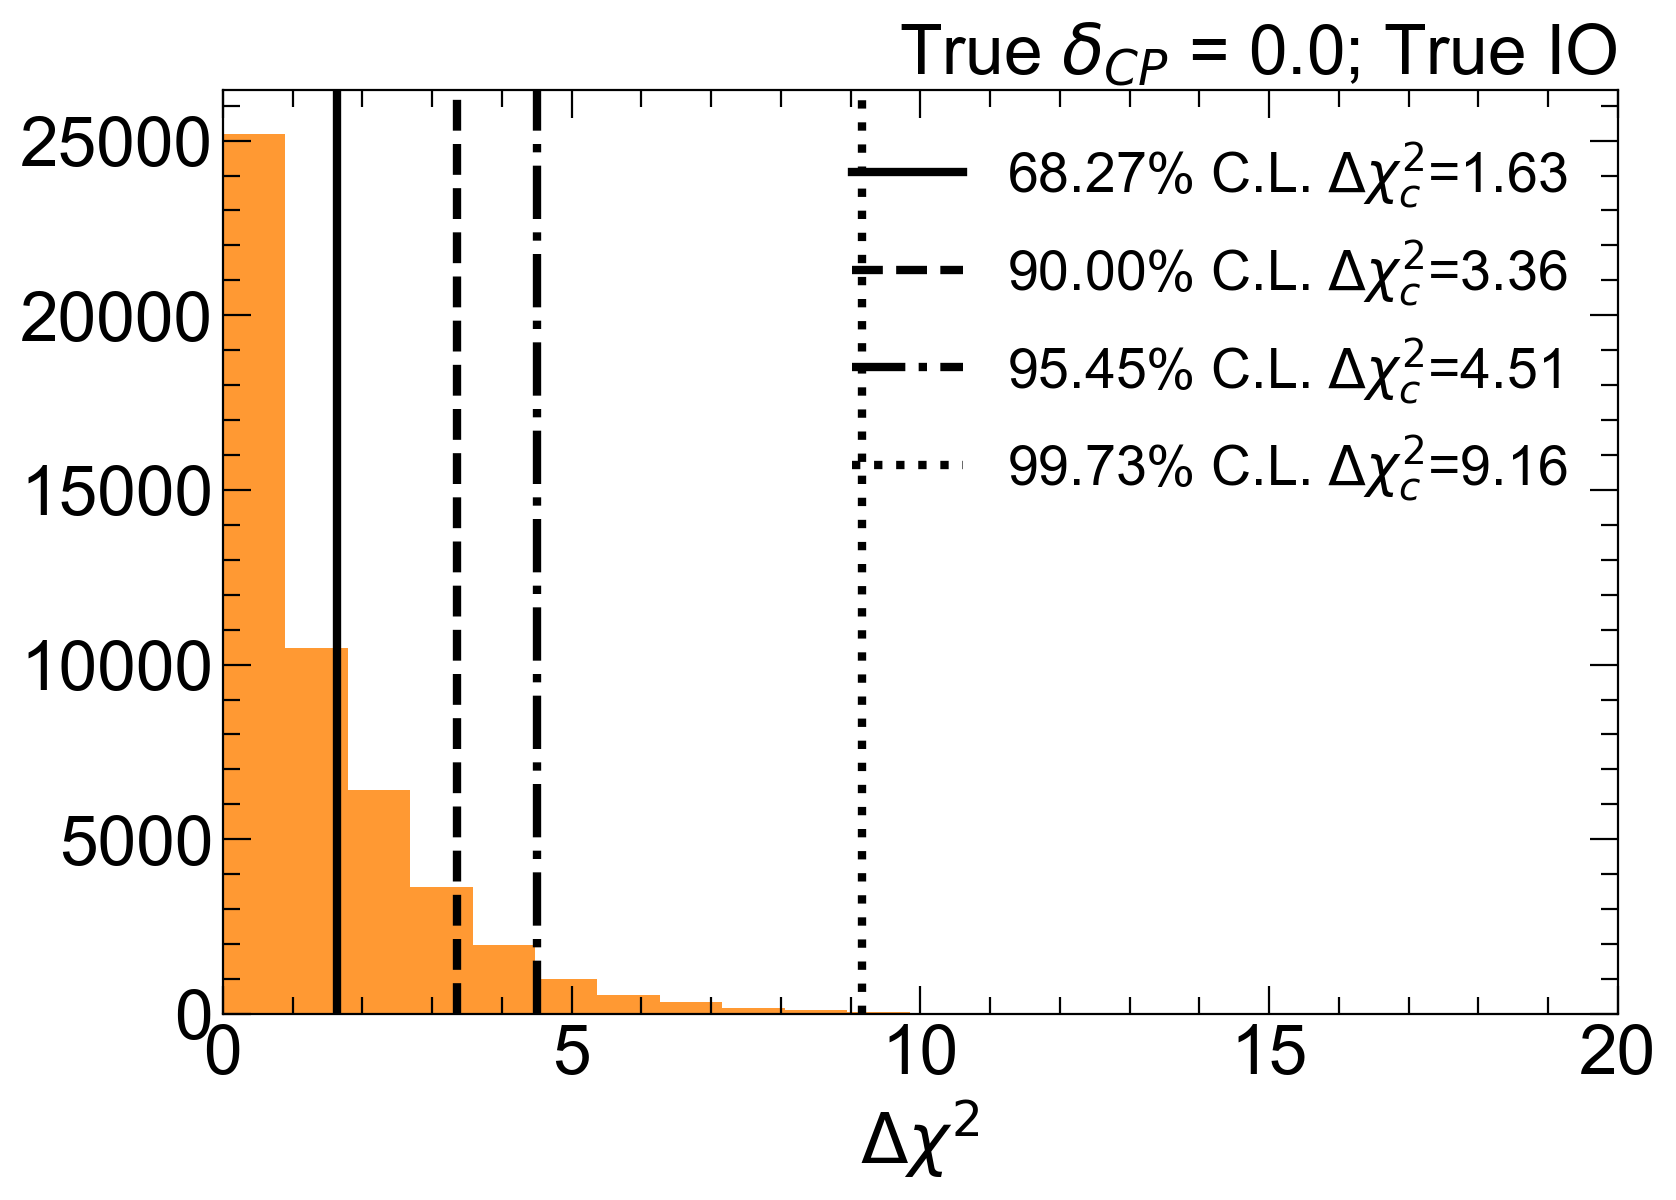

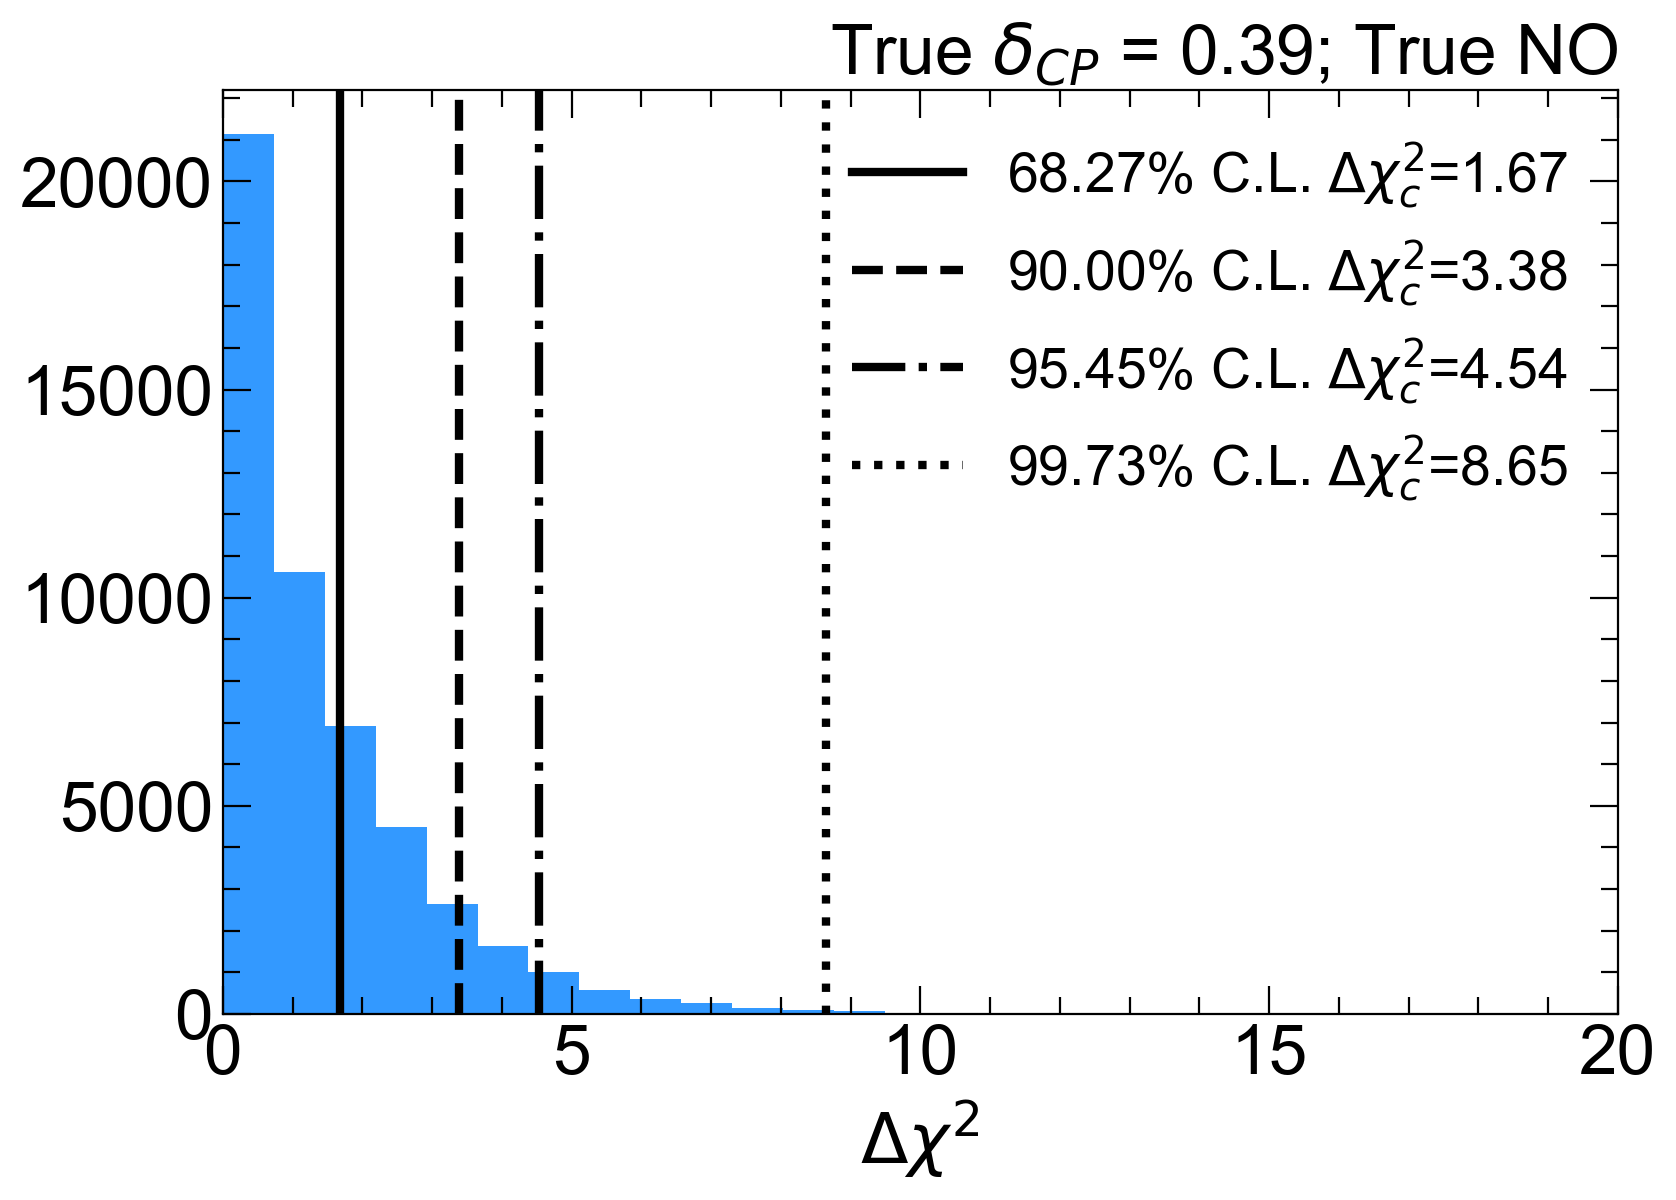

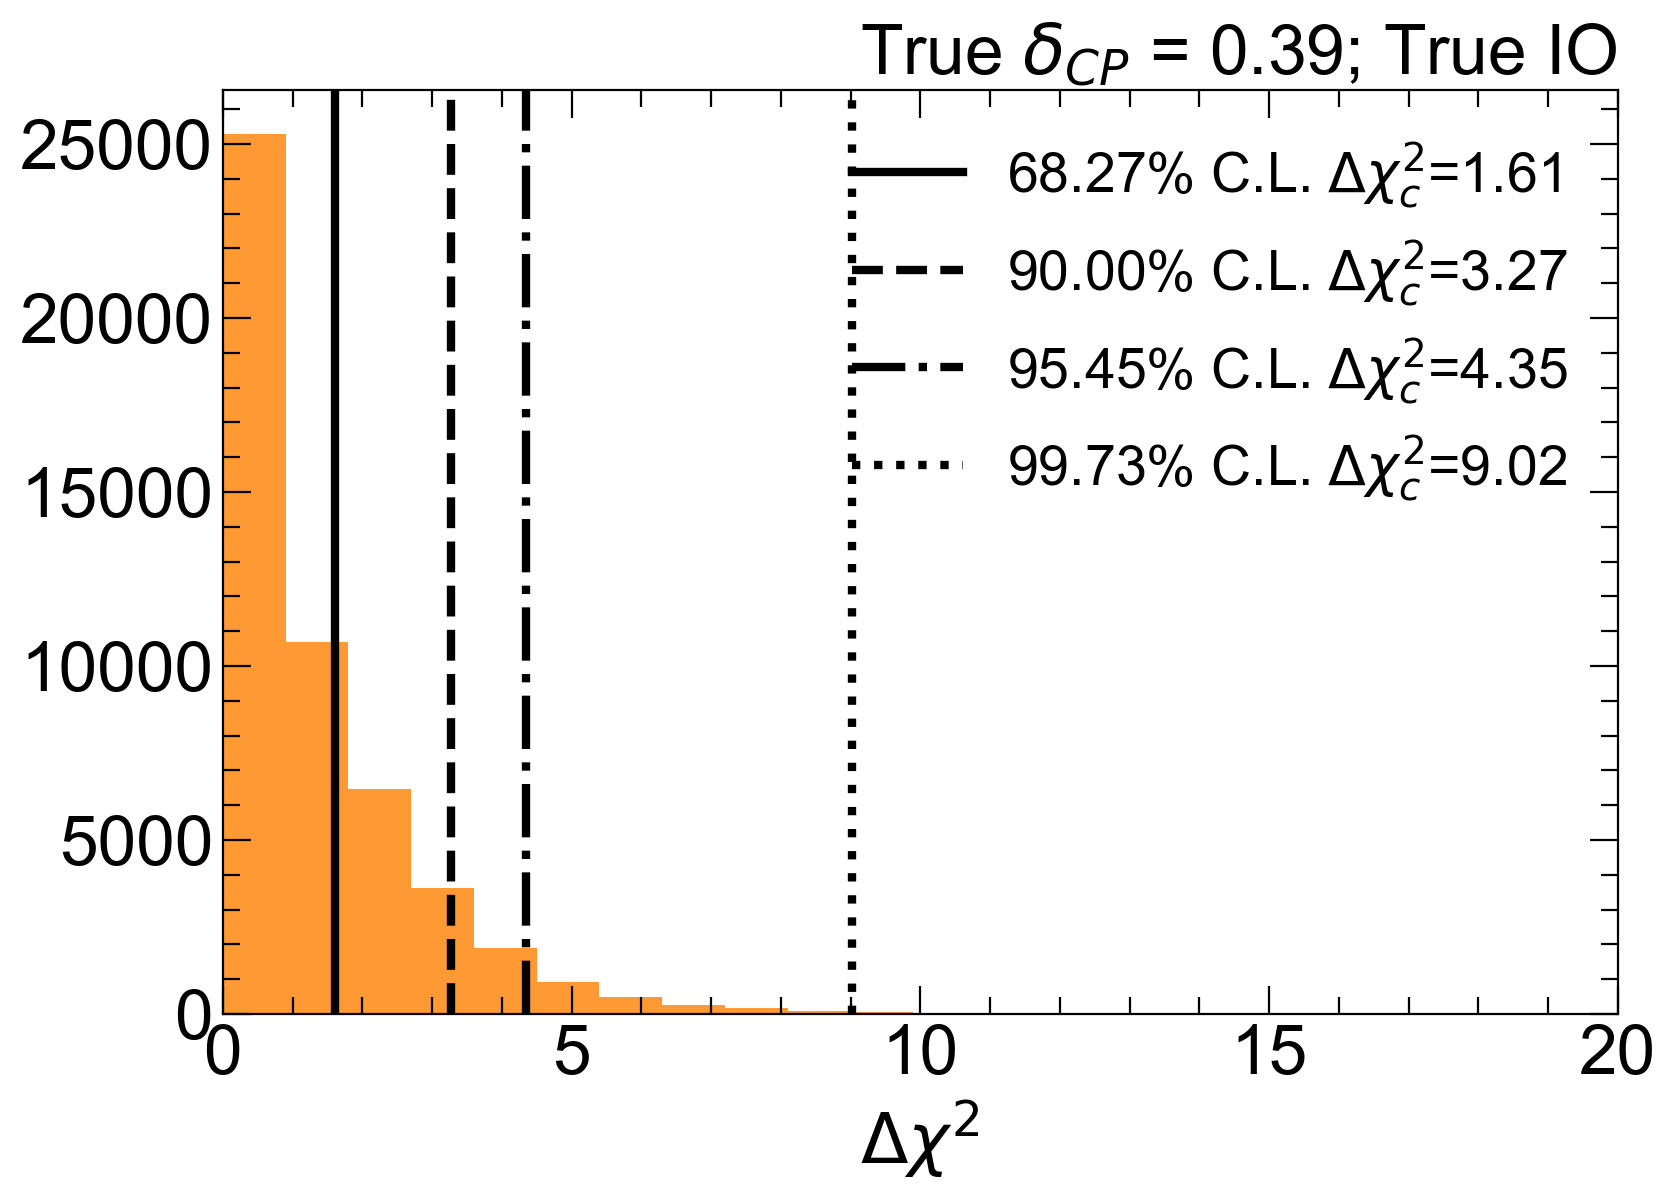

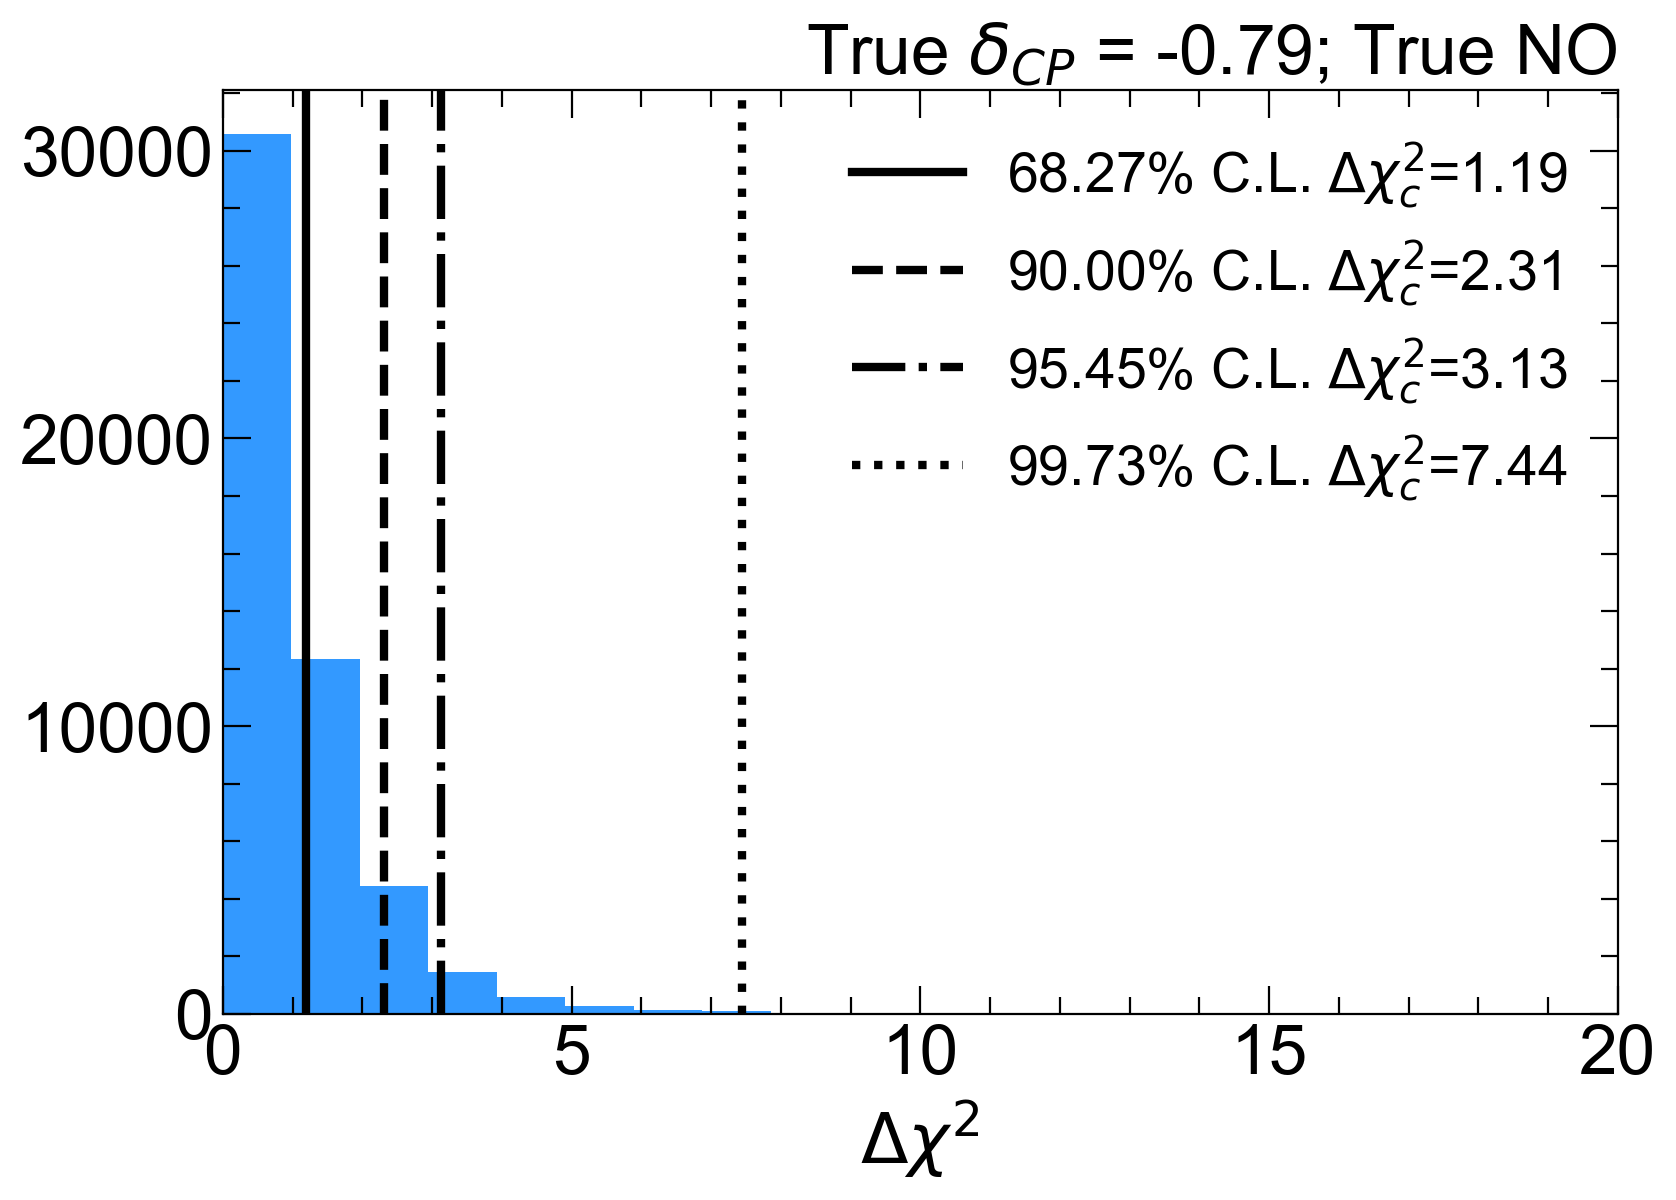

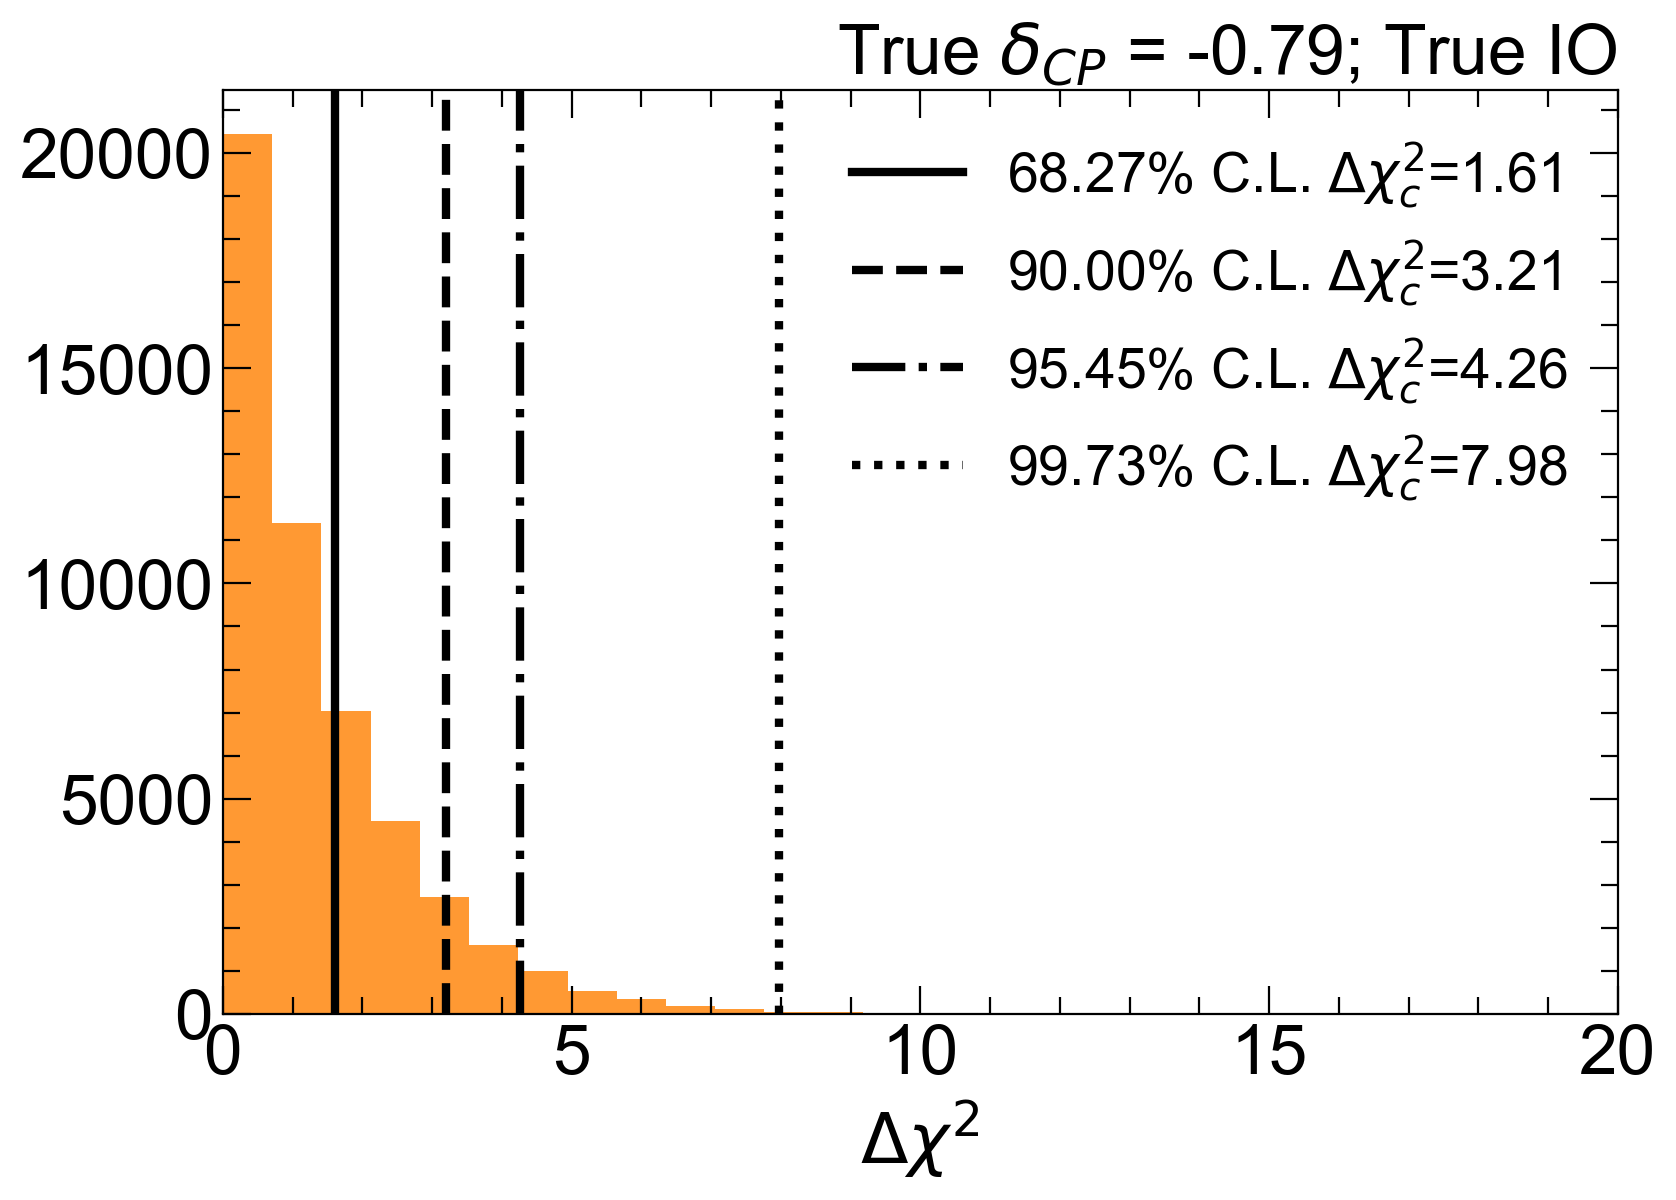

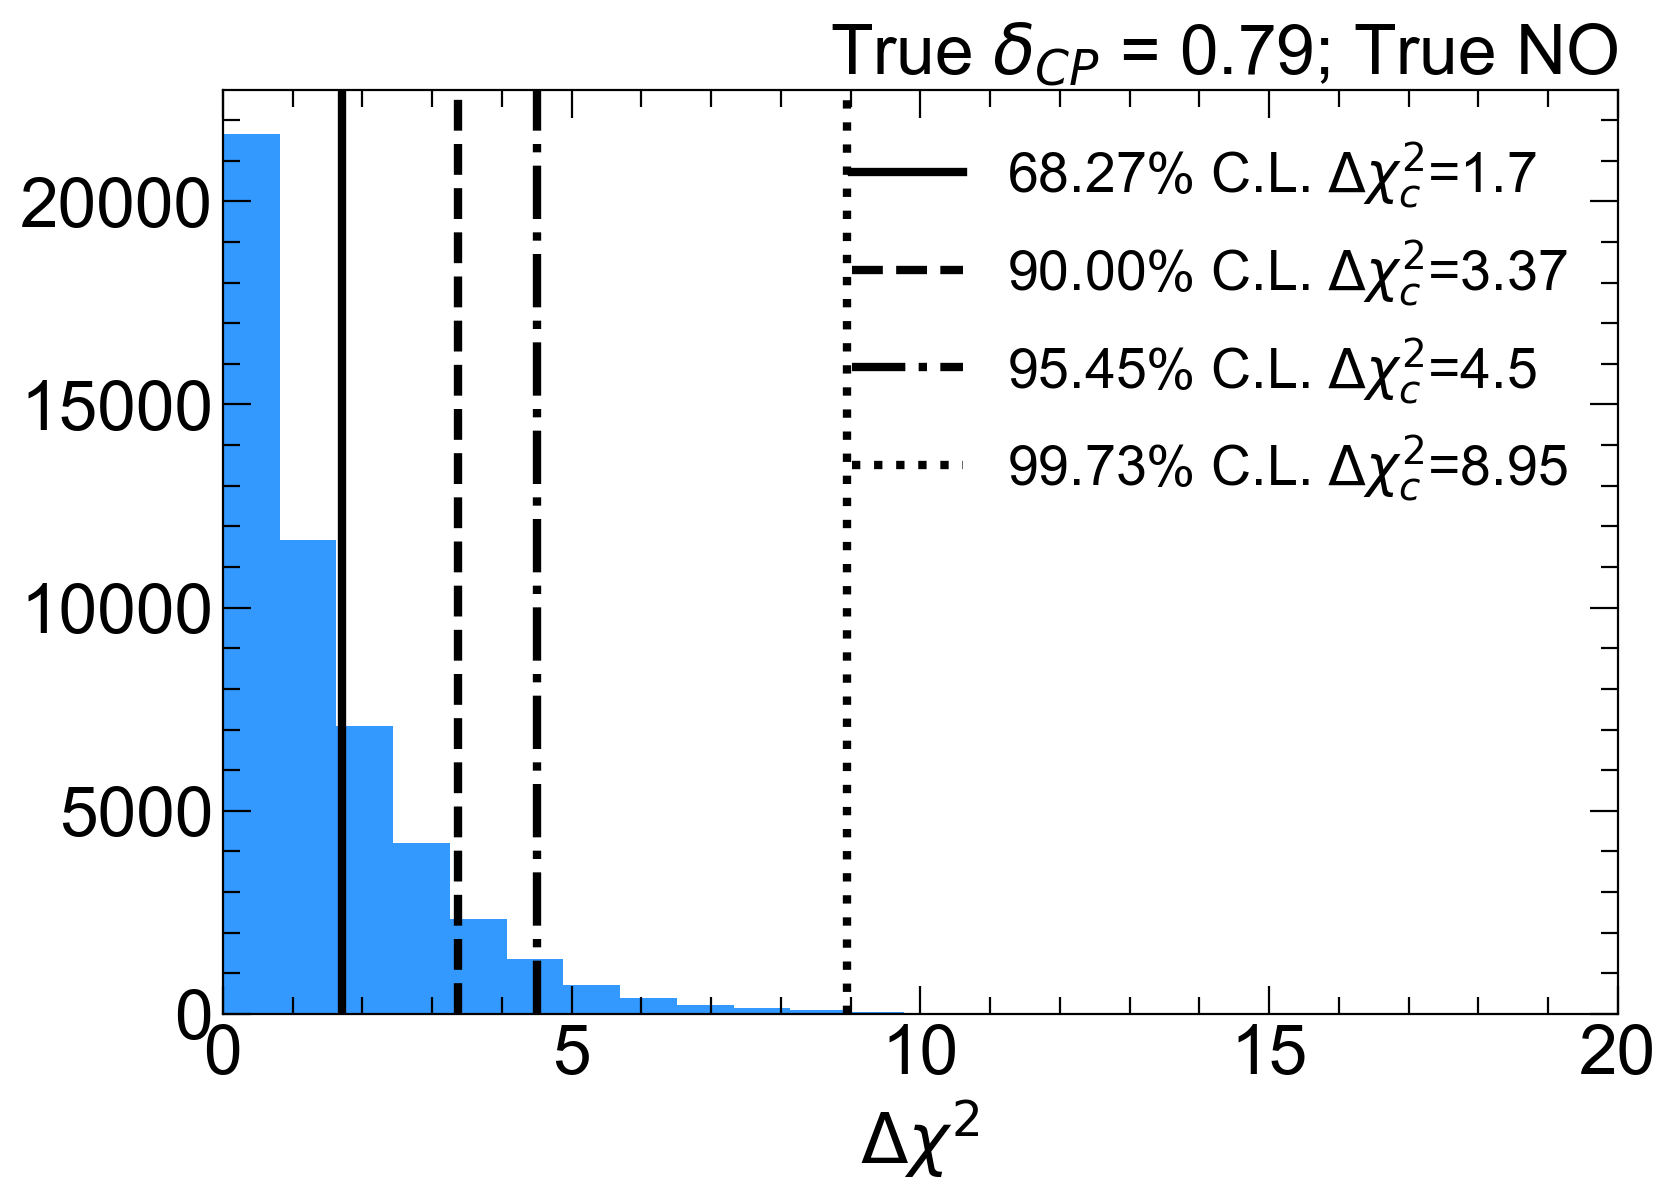

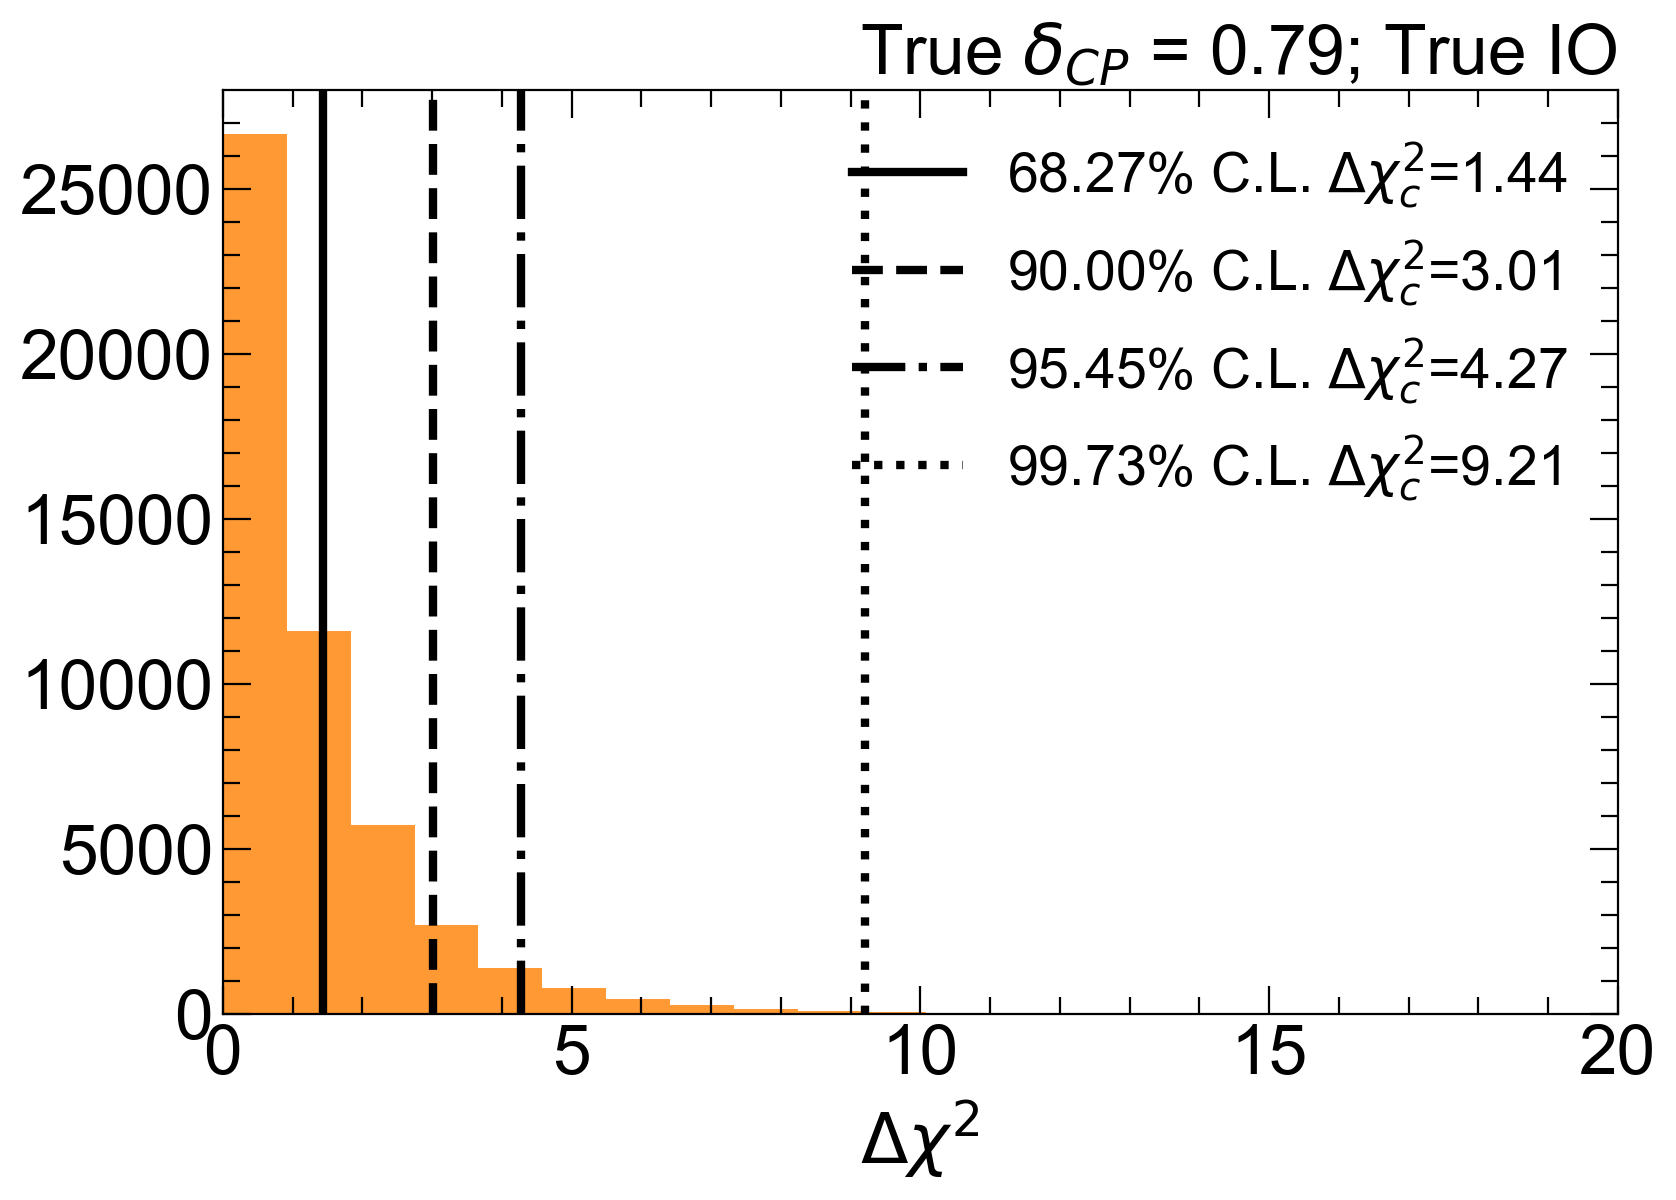

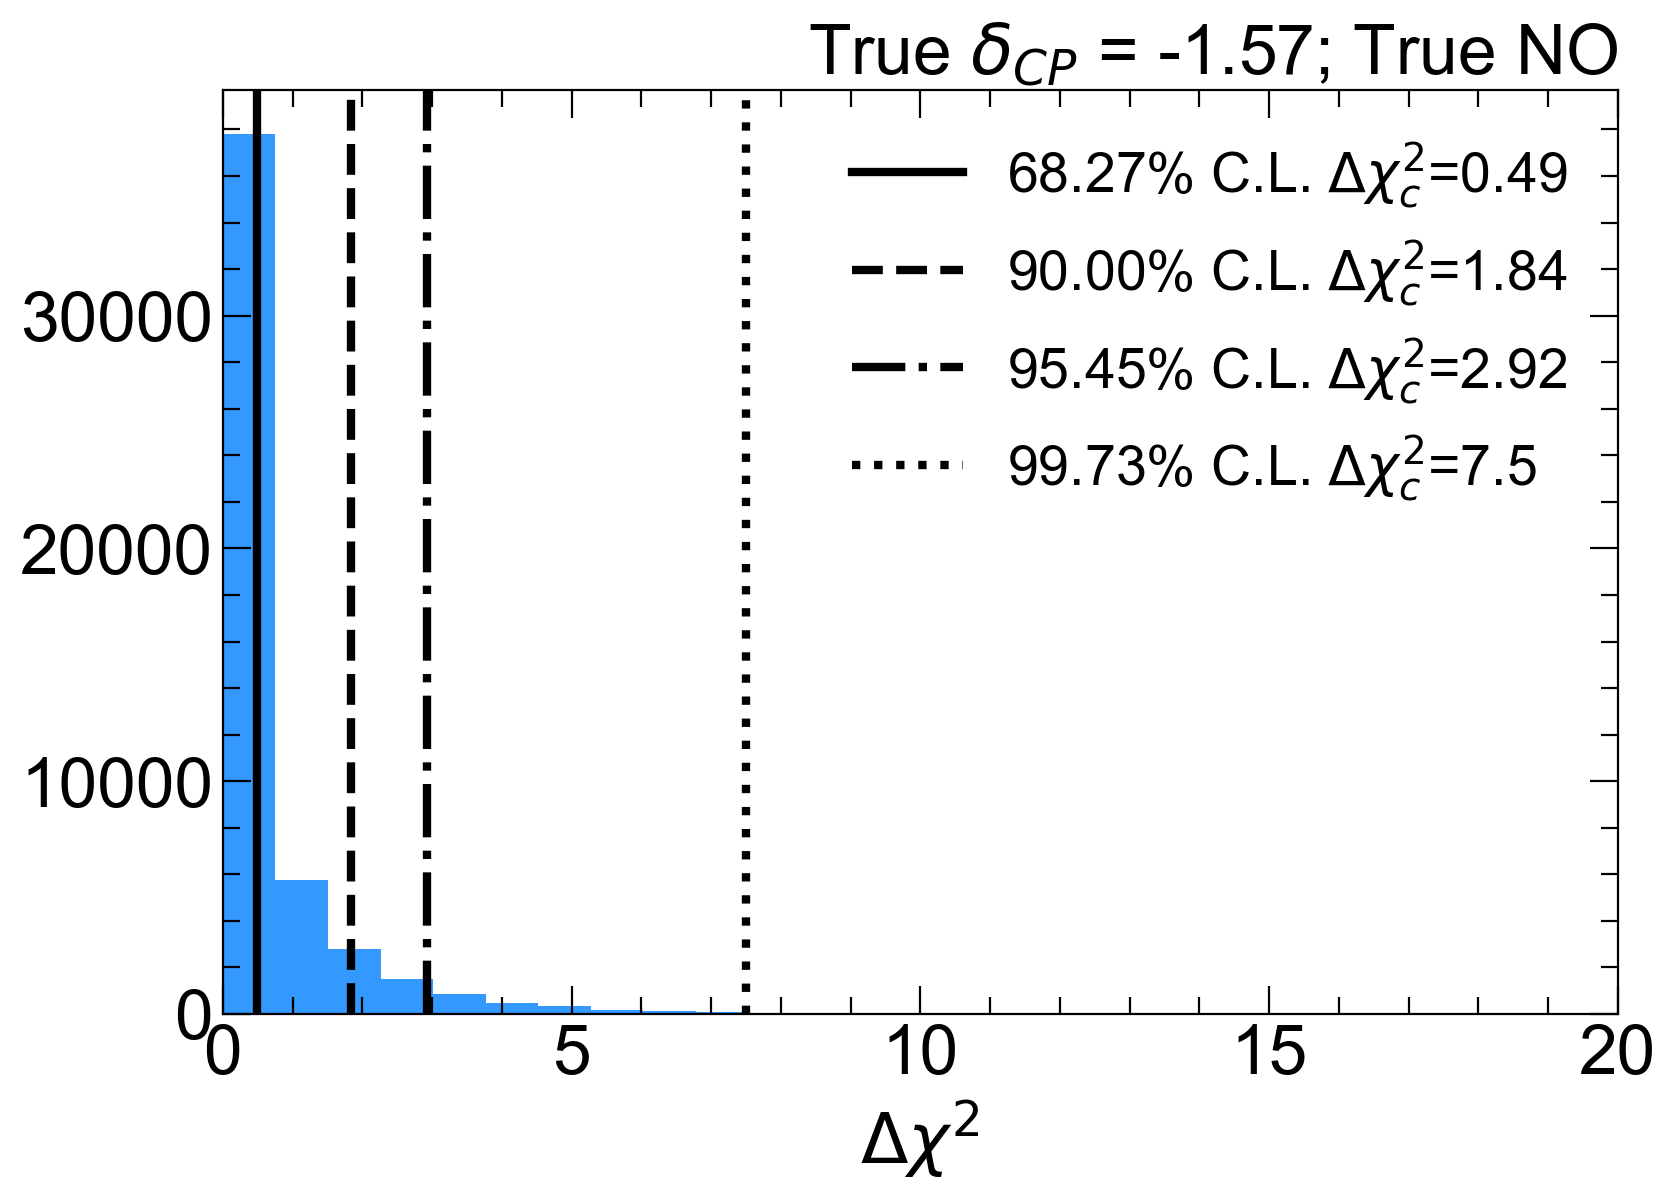

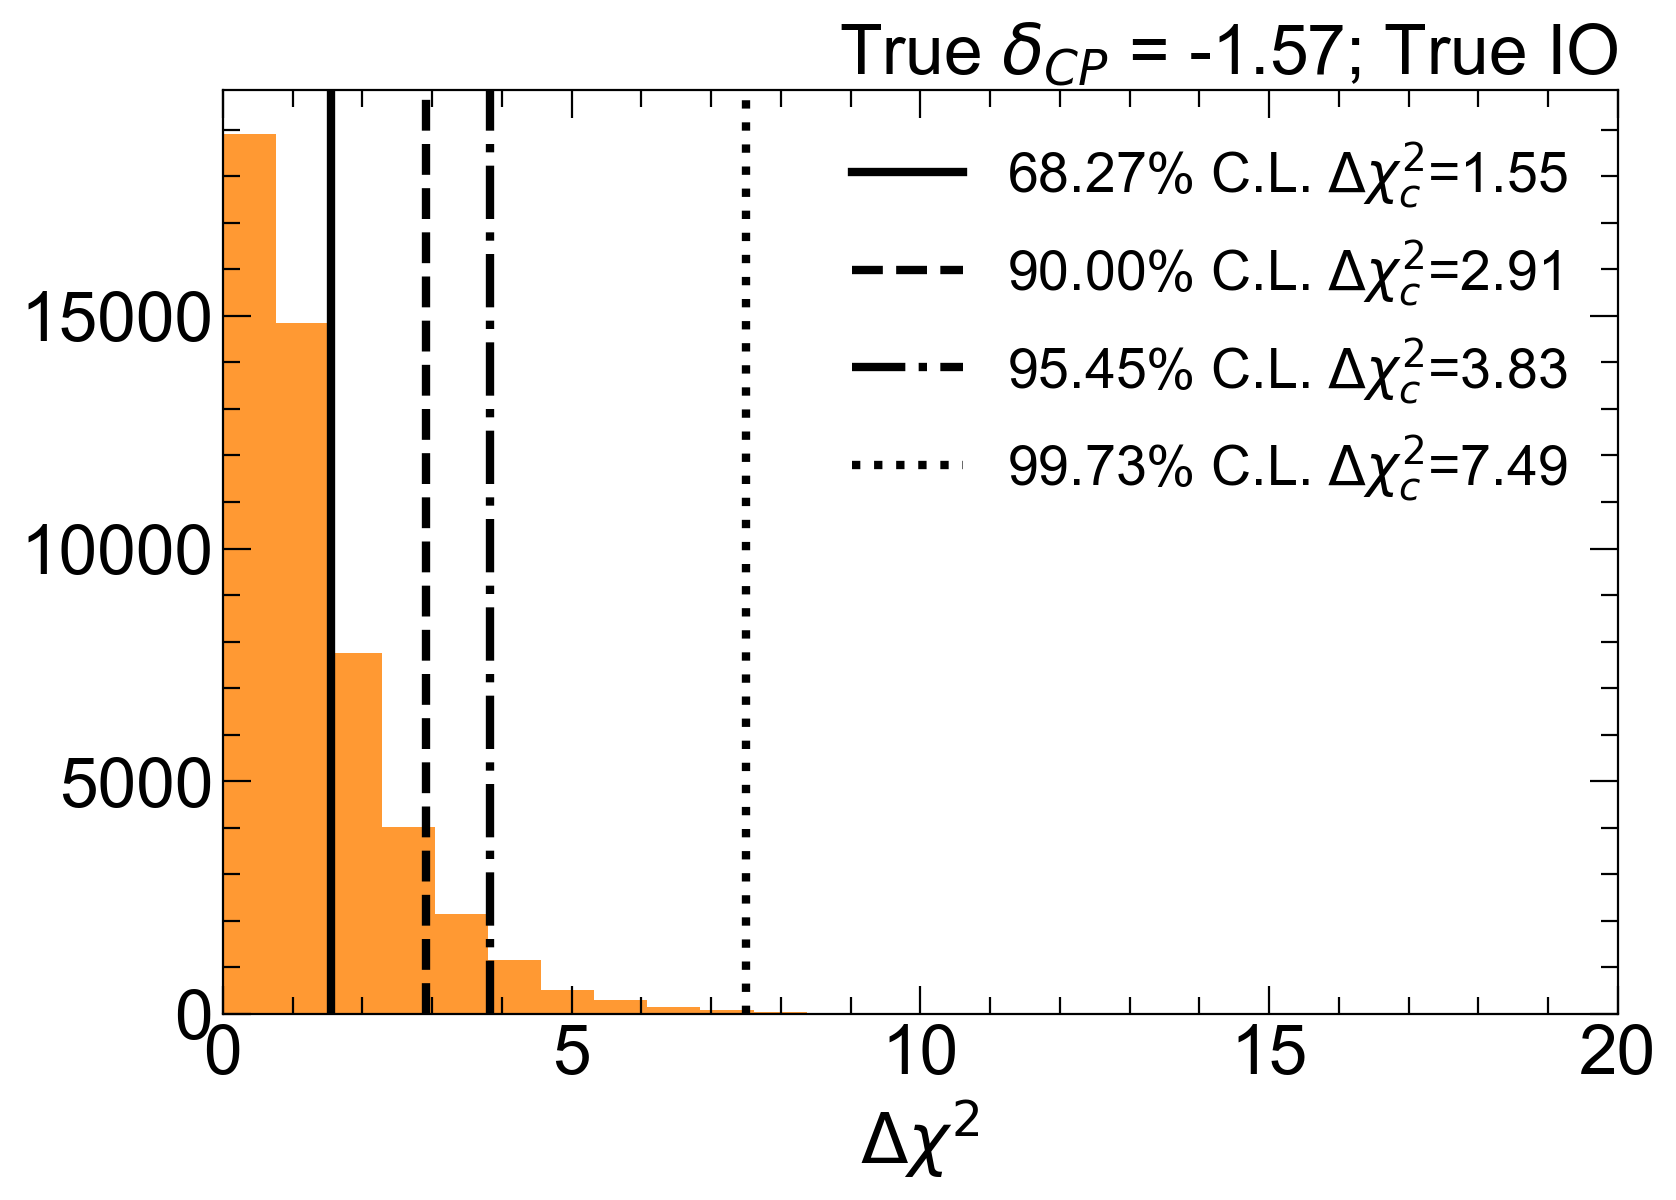

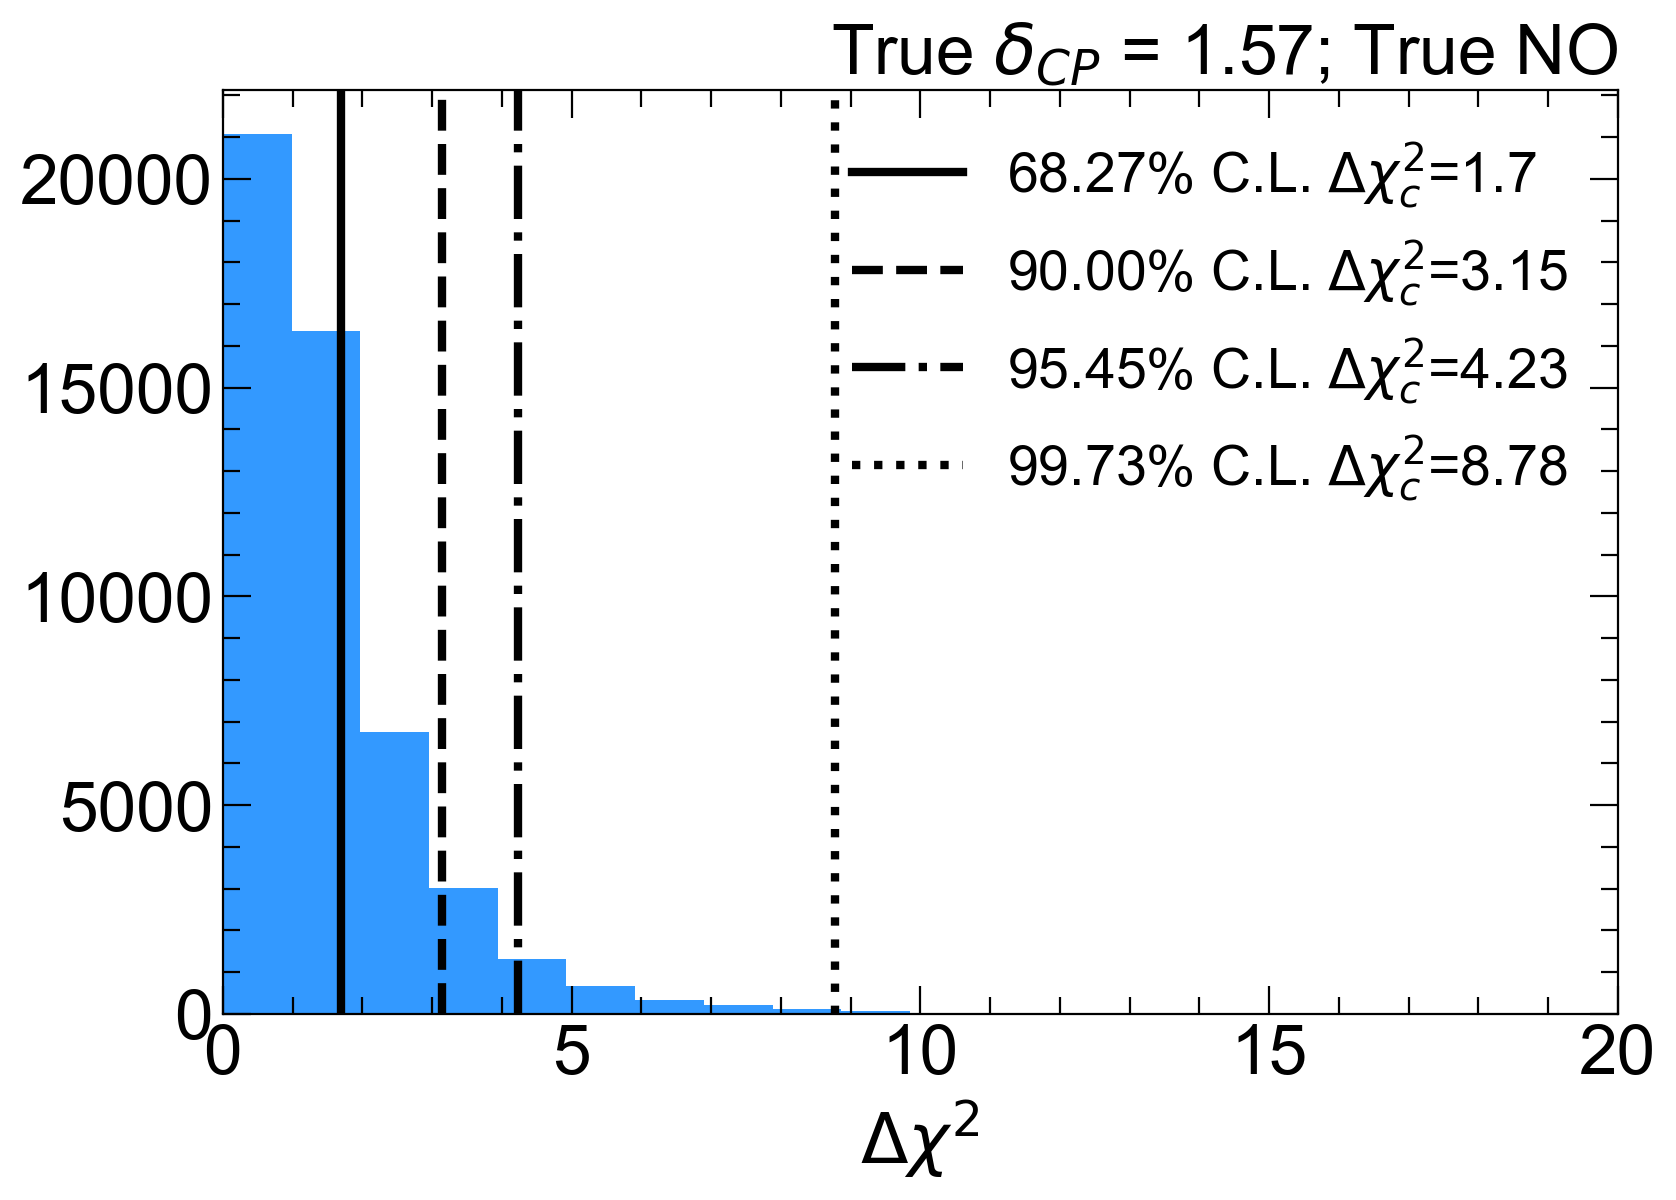

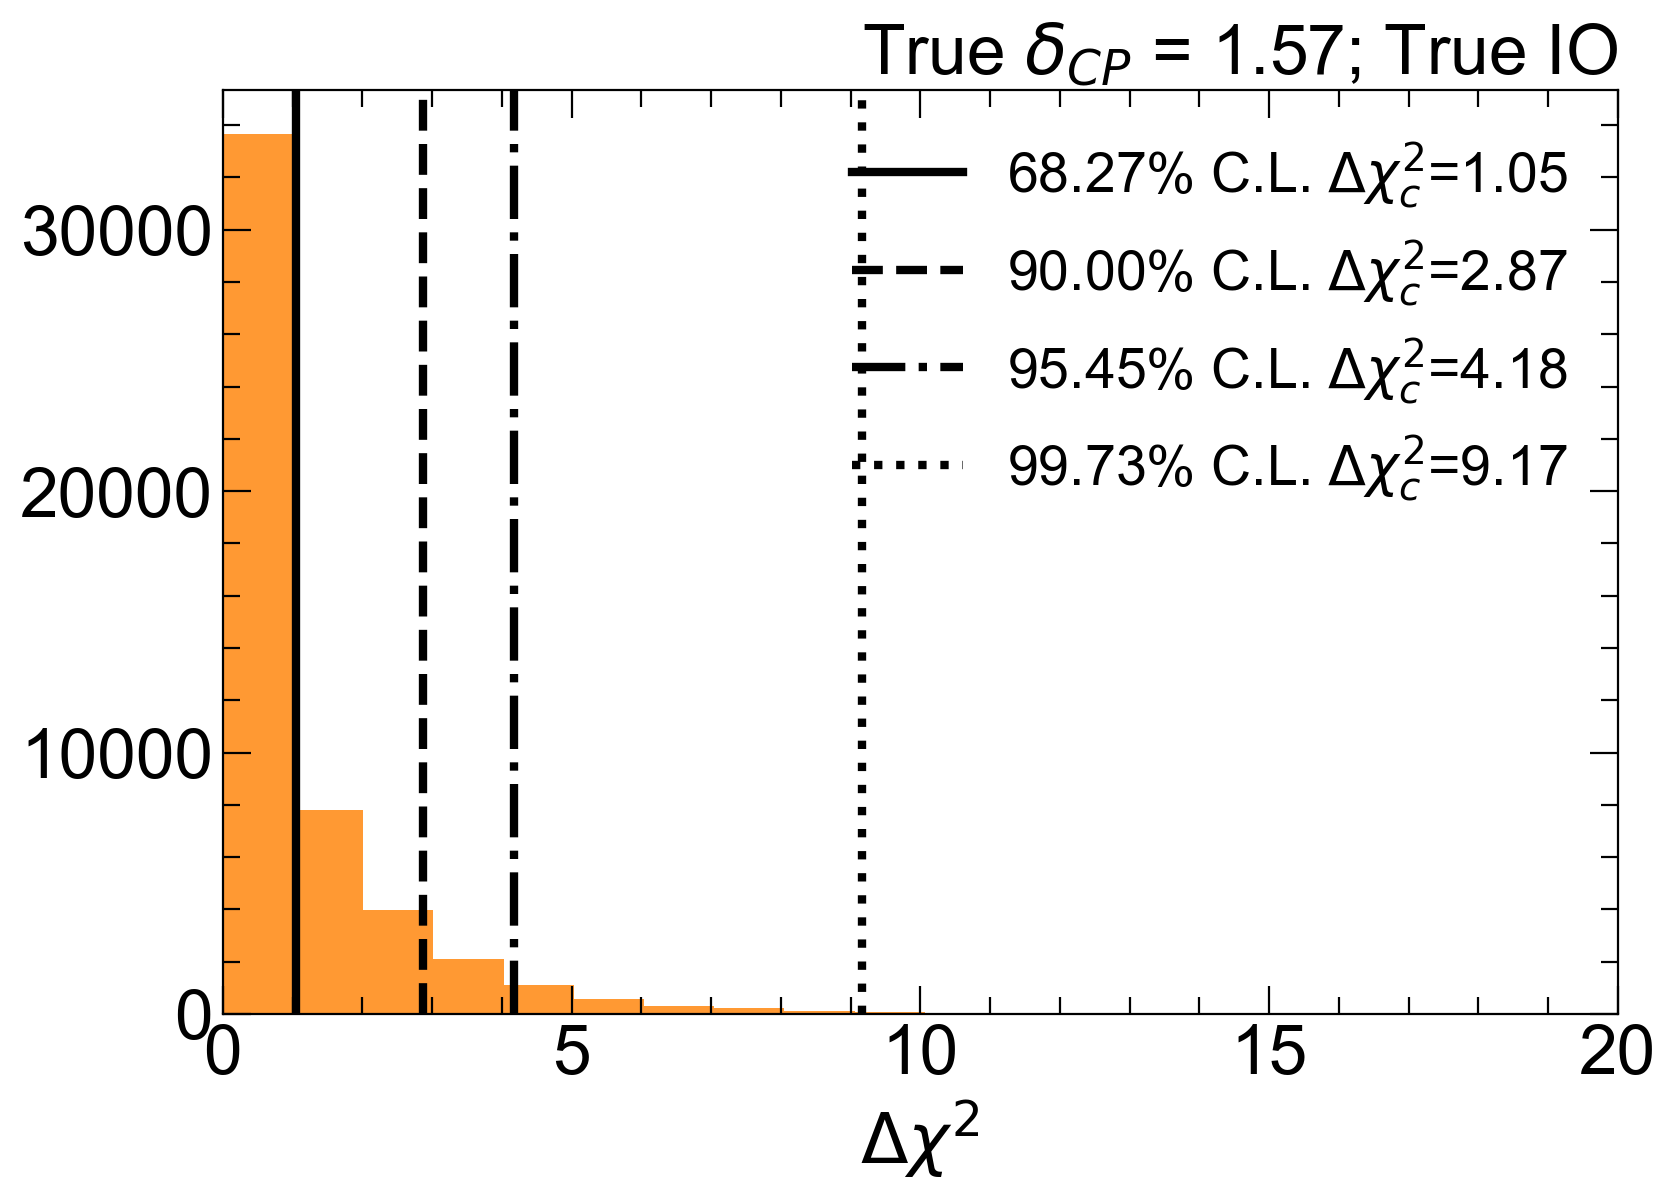

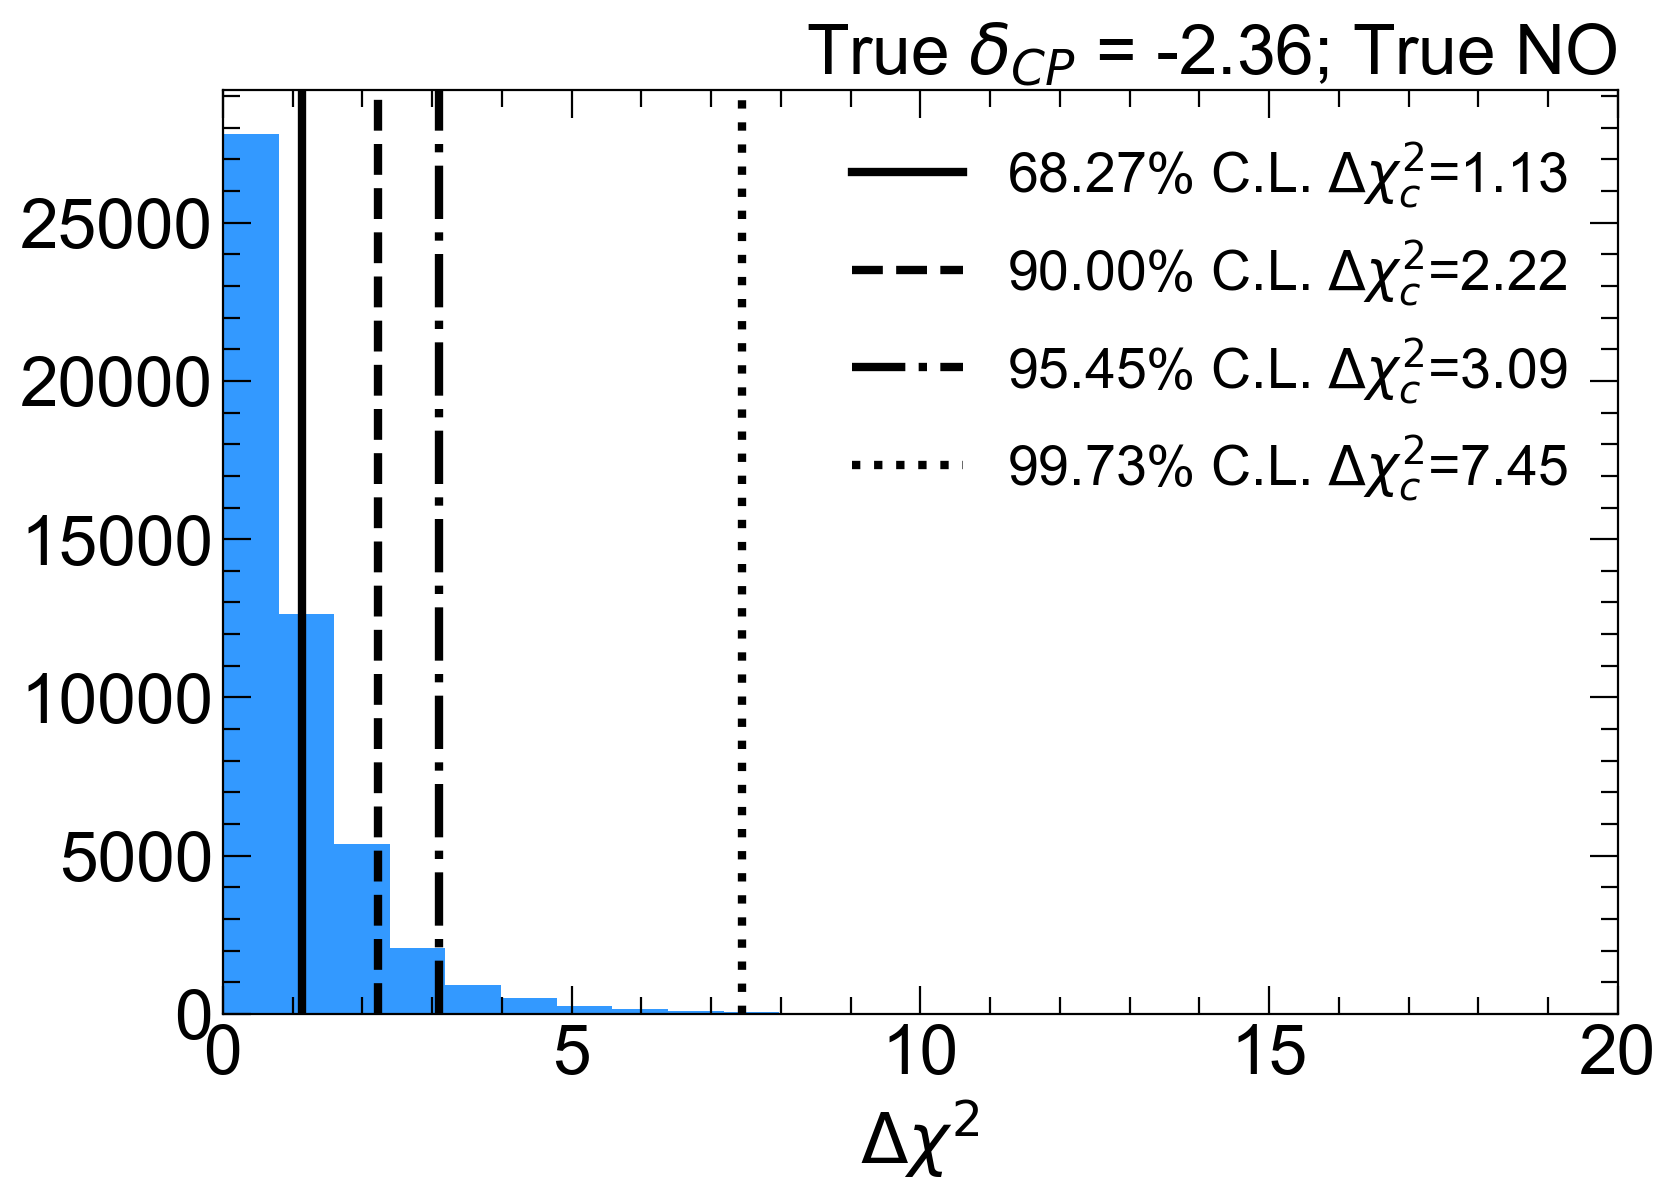

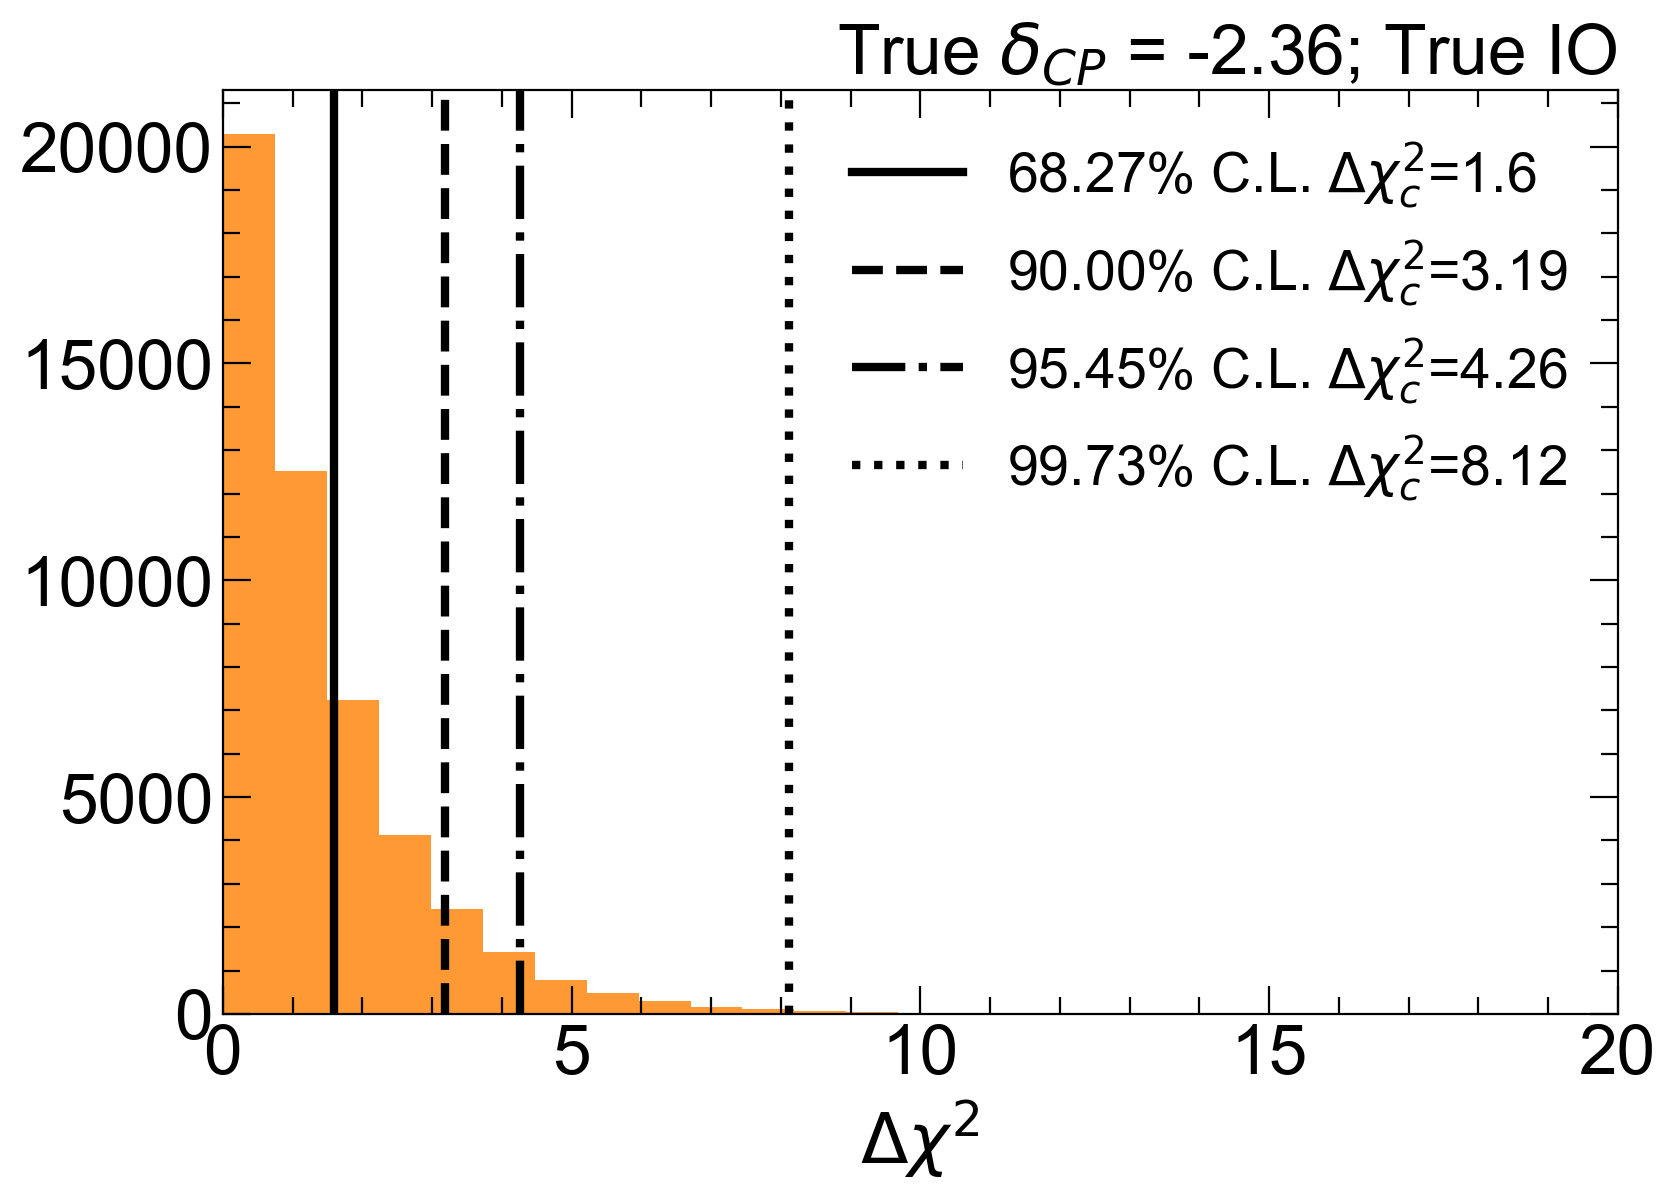

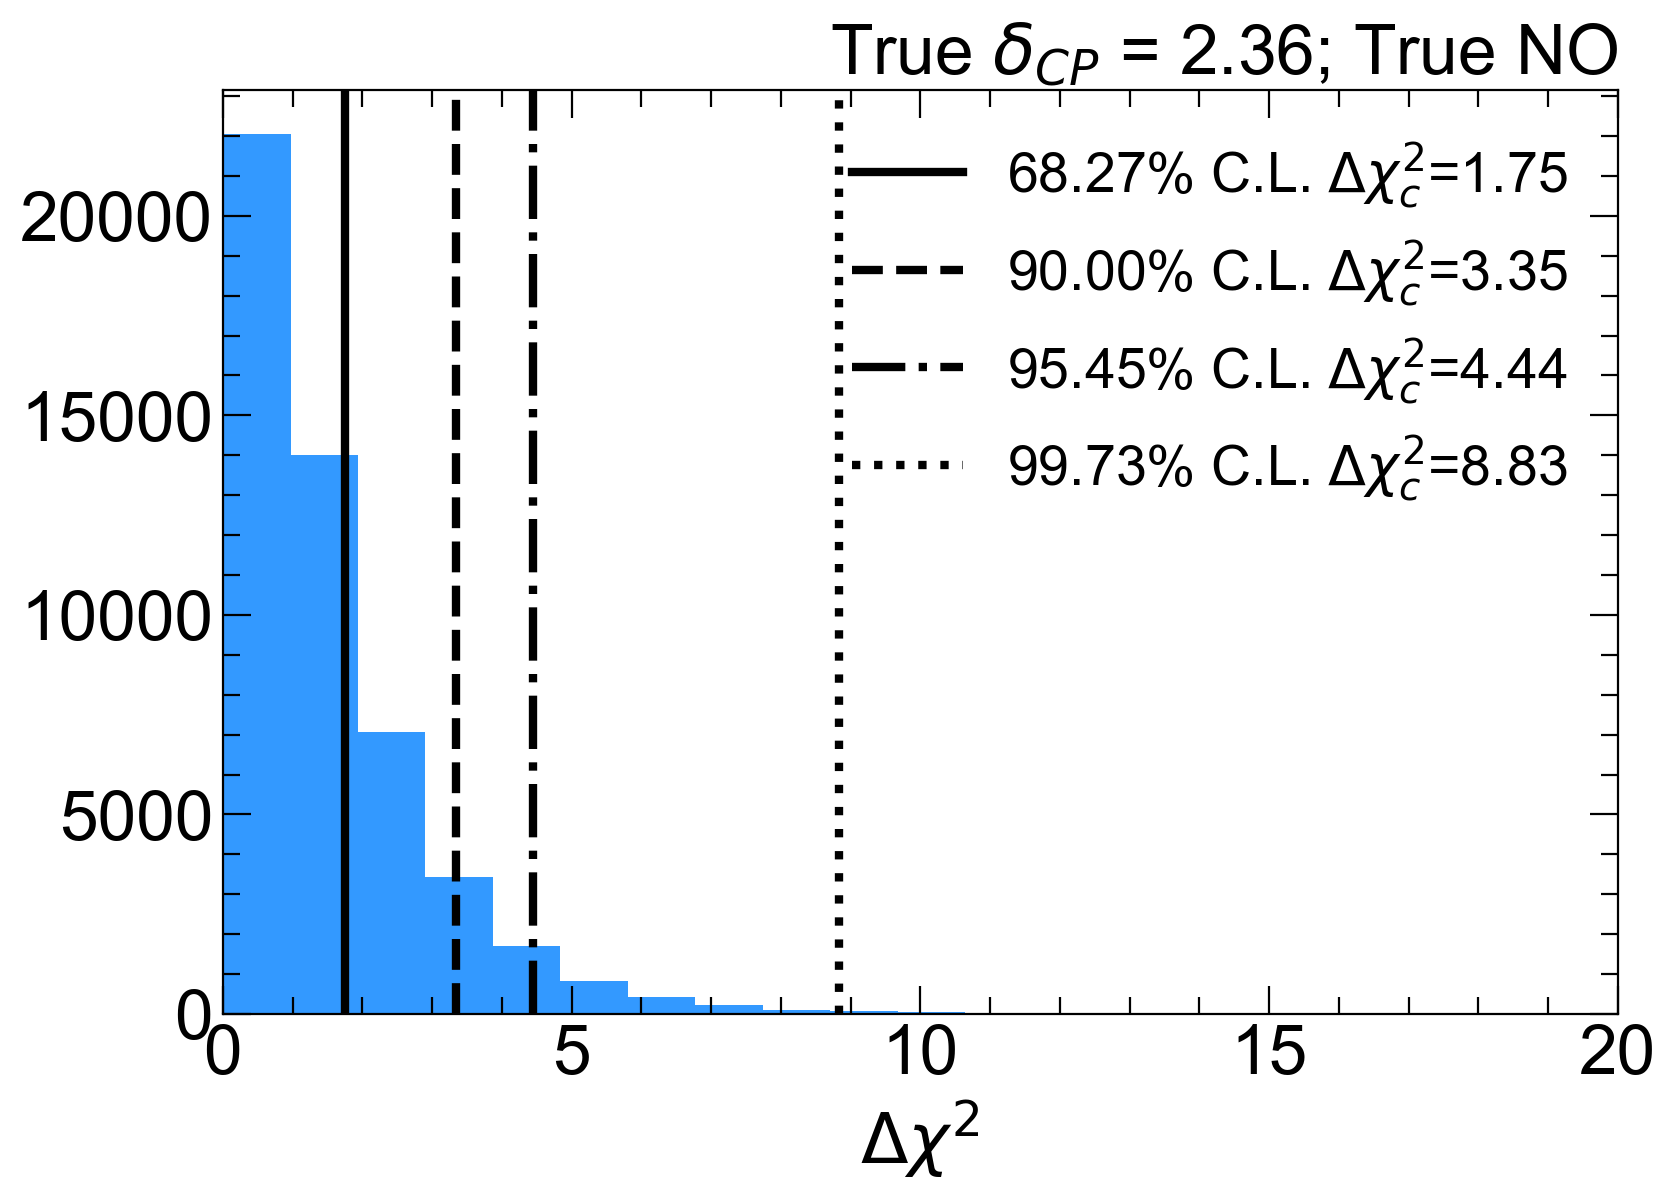

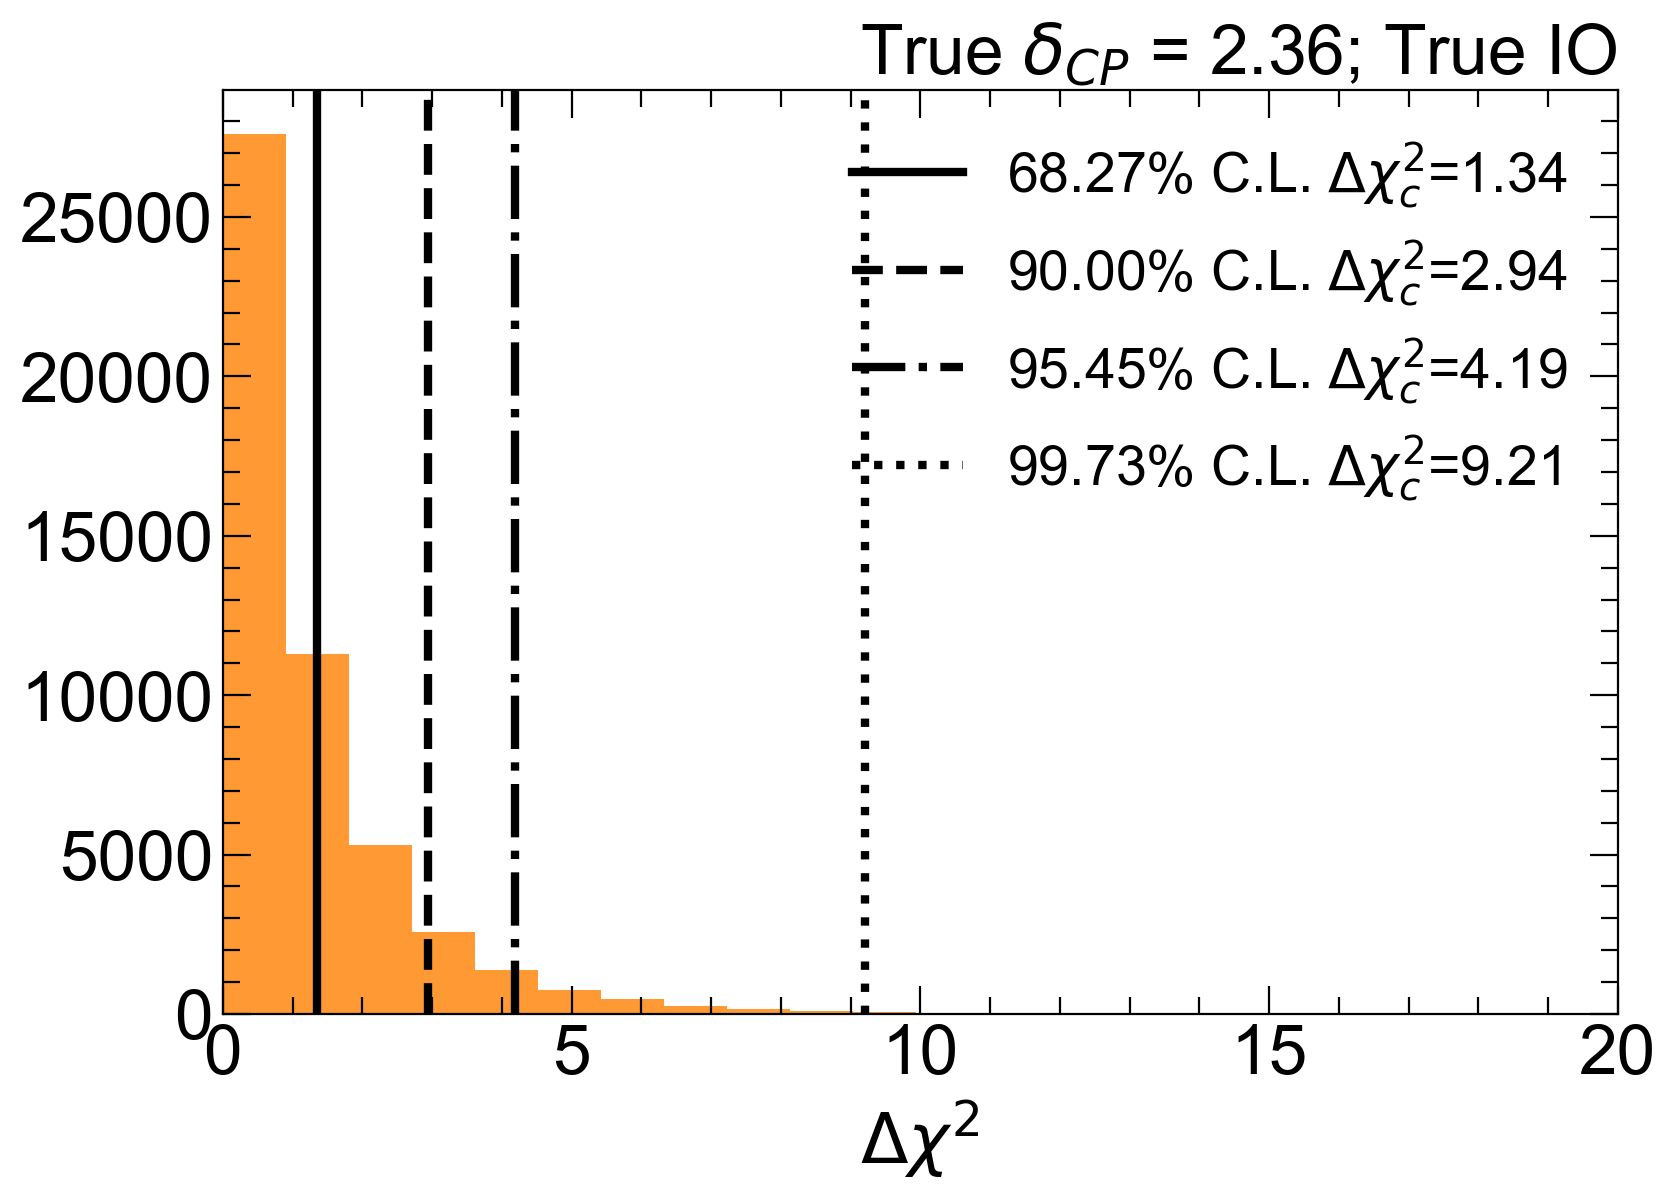

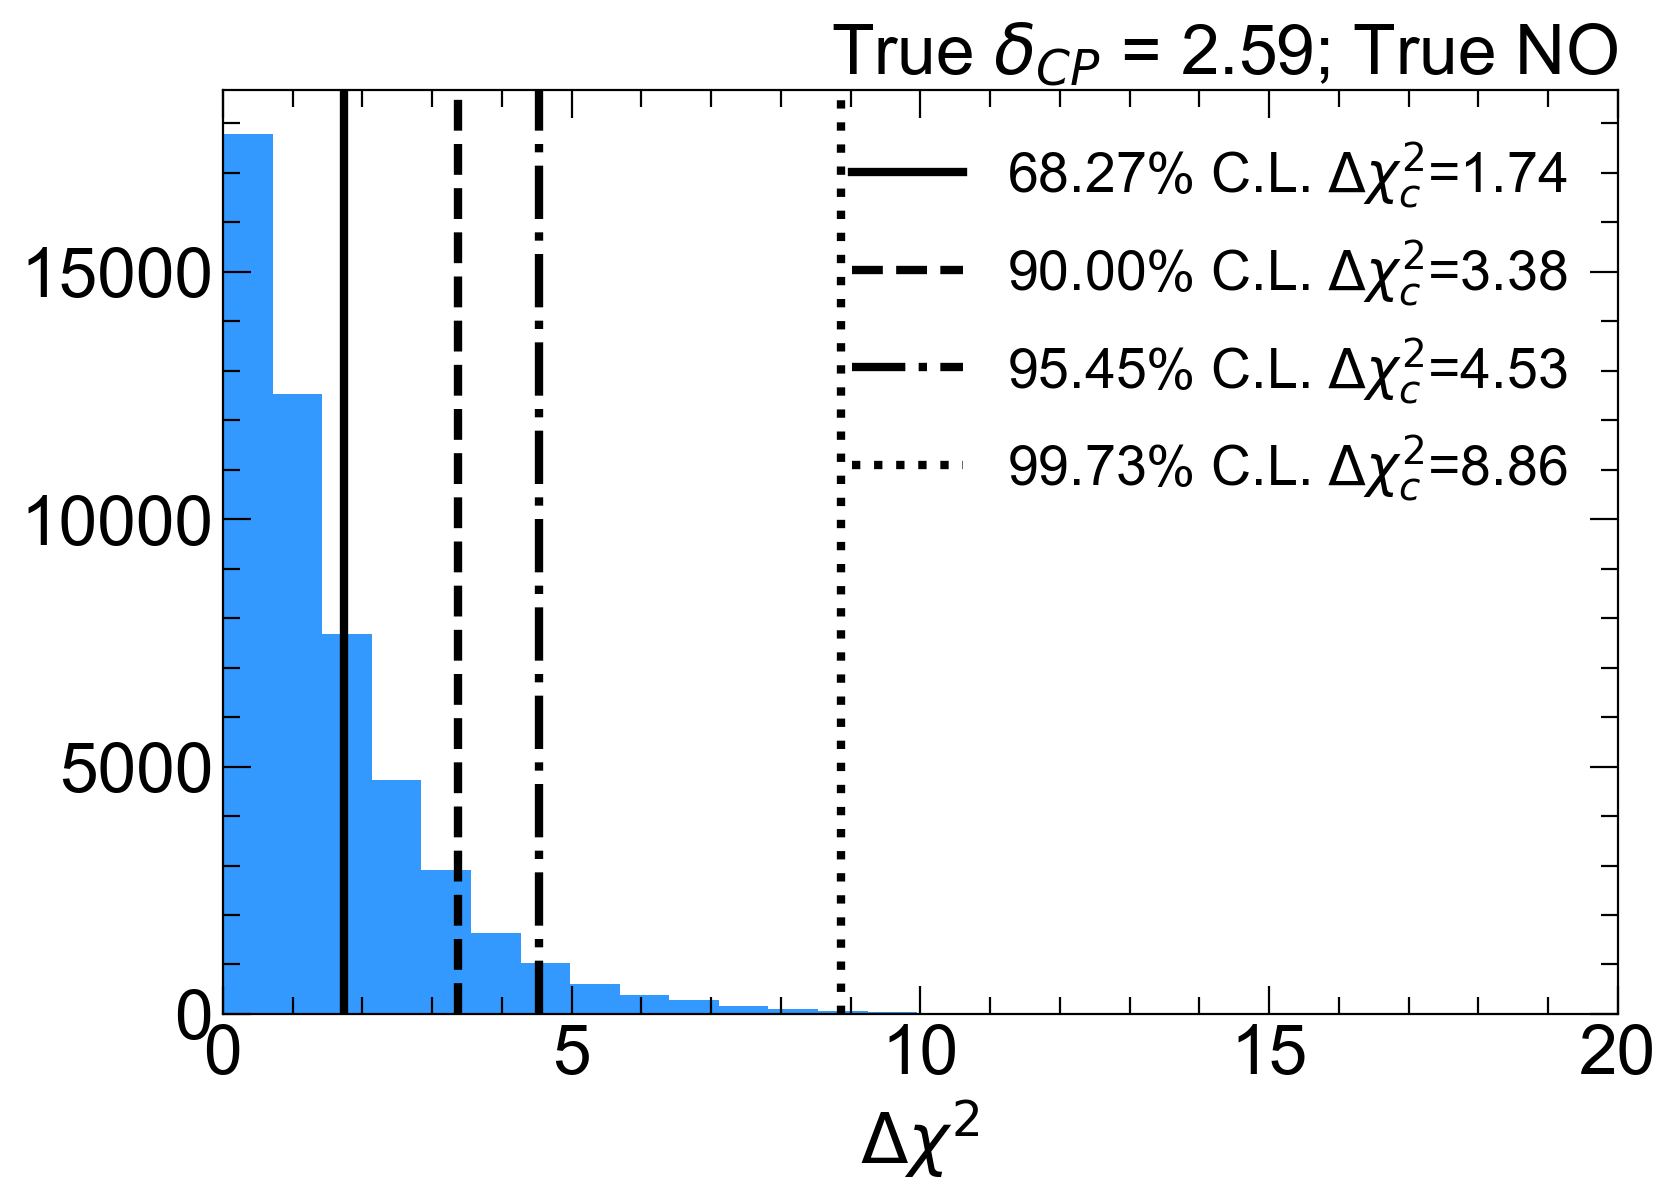

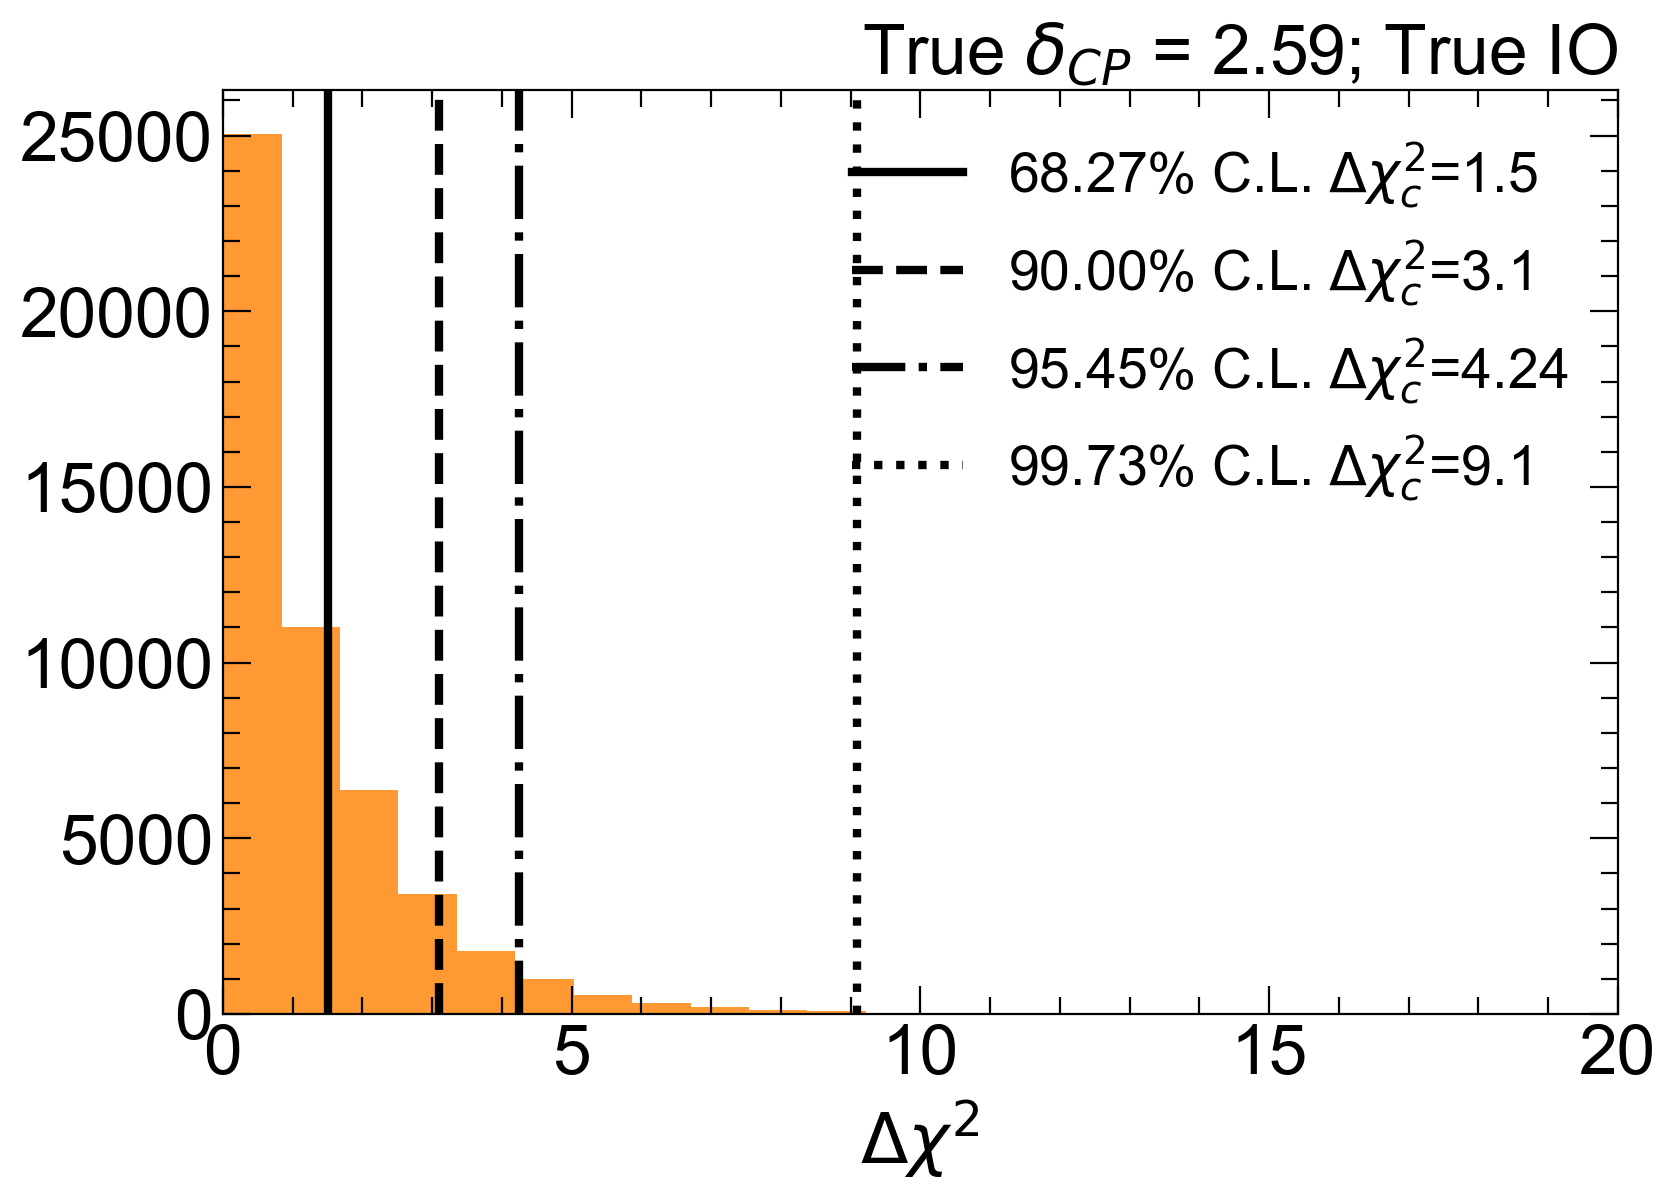

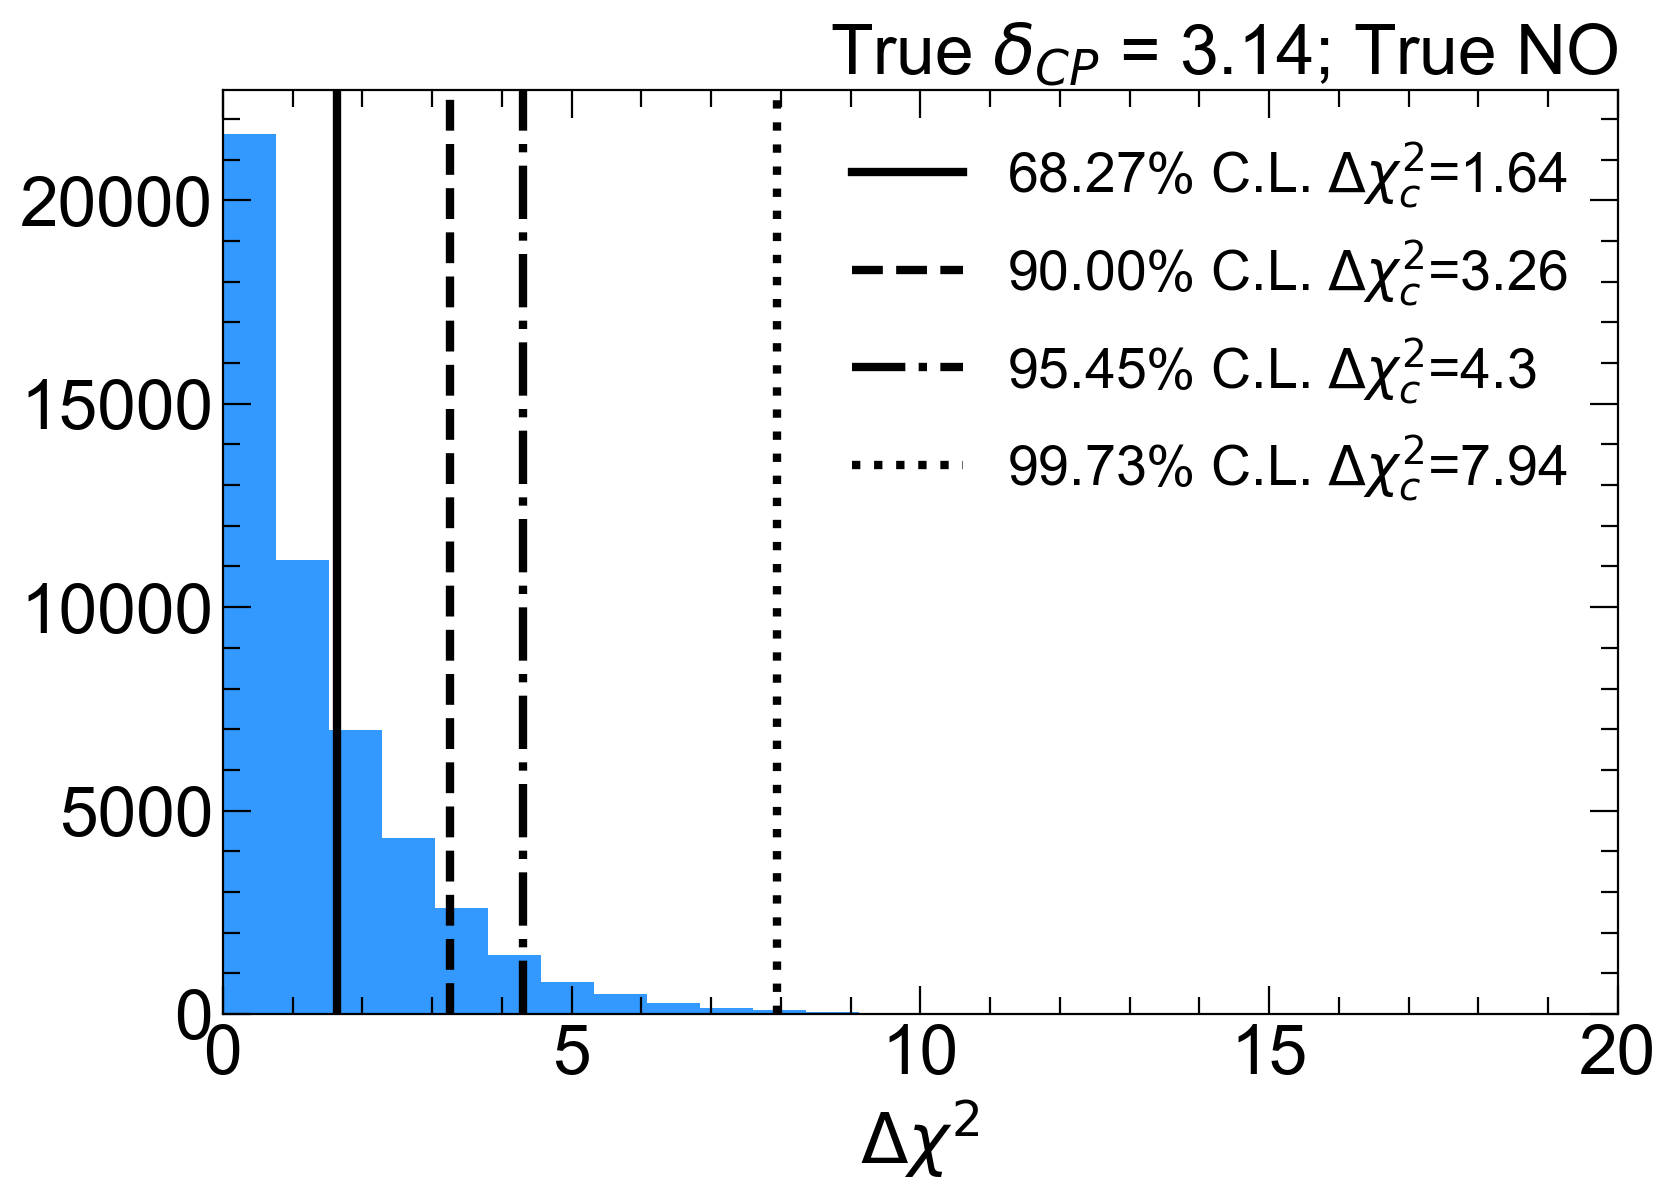

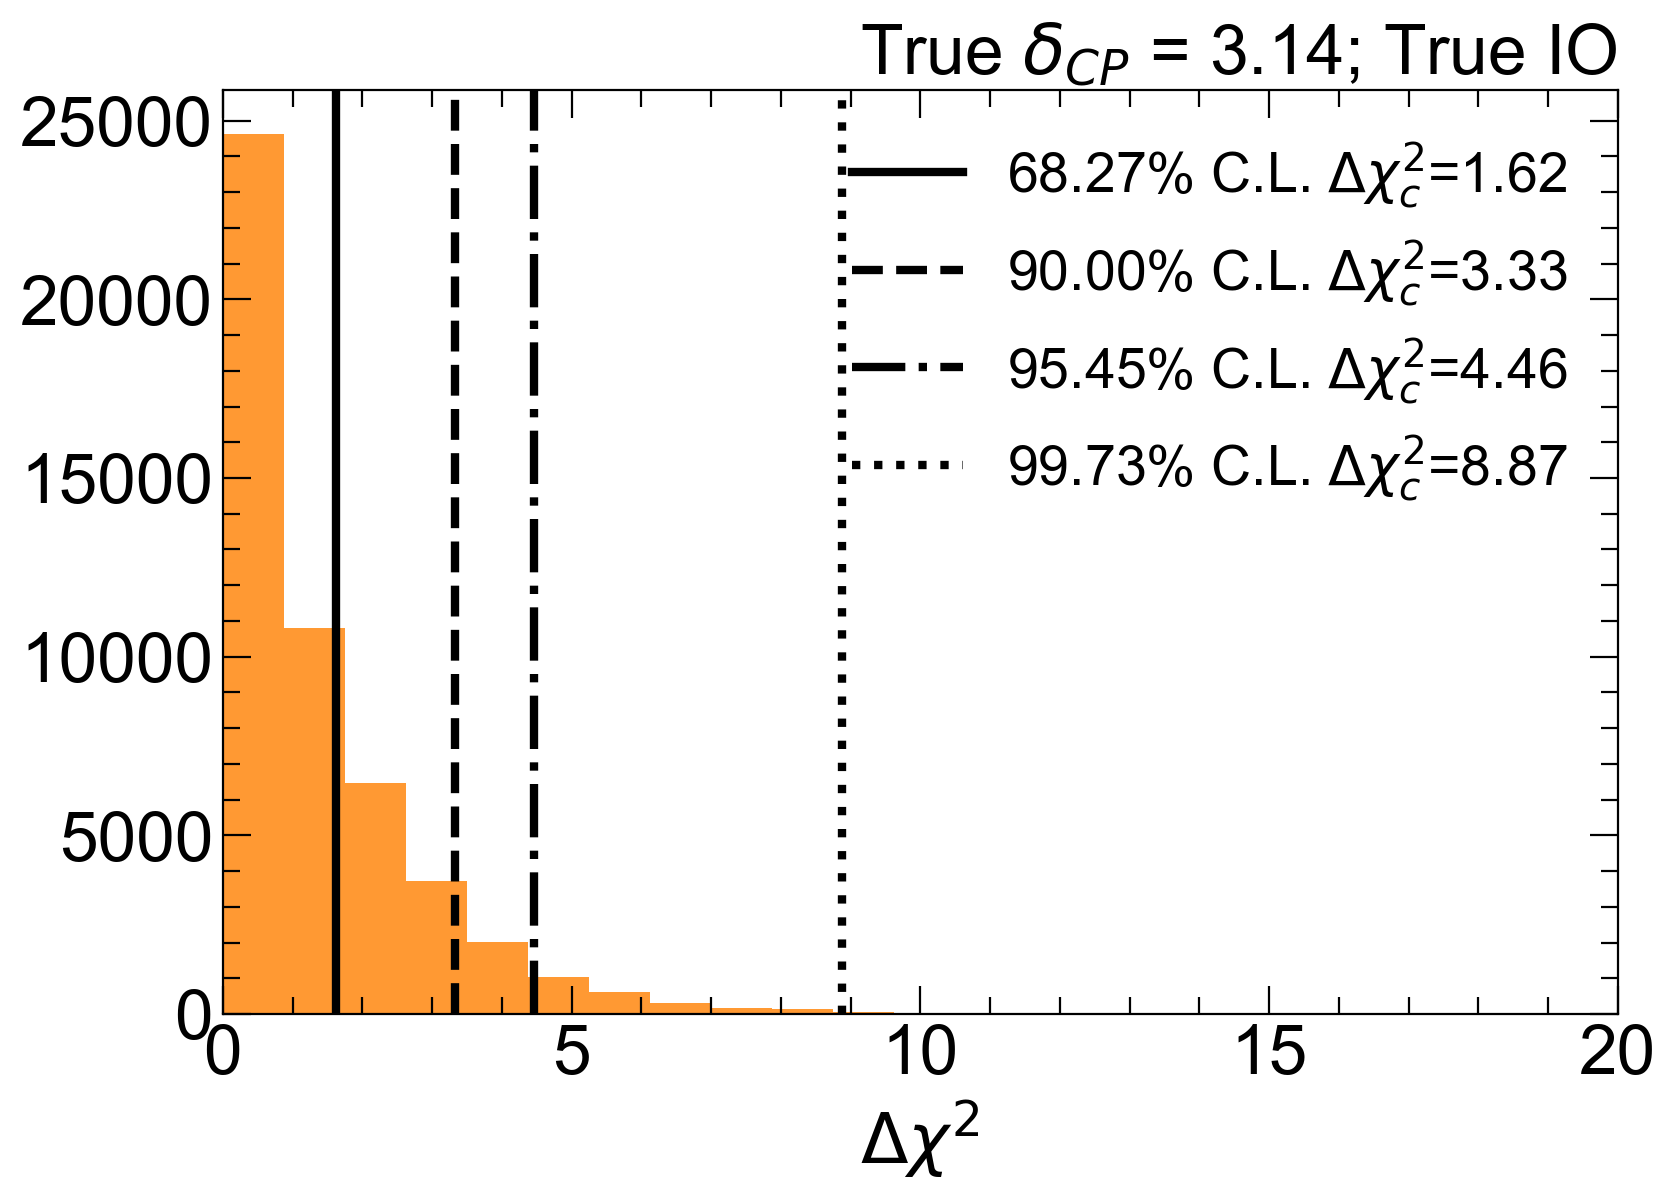

In [12]:
from pythetatools.base_analysis import cl_for_sigma

levels = [cl_for_sigma(z_score) for z_score in [1, 2, 3]]
levels = levels + [0.9]
lss = ['-', '--', 'dashdot', 'dotted']
levels.sort()
labels = ['68.27%', '90.00%', '95.45%', '99.73%']

for true_param_str in param_values_FC[param_name]:
    for true_mh in [0, 1]:
        true_param = float(true_param_str)
        basename_directory = f"MargTemplates_LucileThesis_fit_FC{suffix[param_name]}_{true_param_str}_{true_mh}_FullSyst_wRC_etheta_ptheta_{param_name}"
        dir_ver = 'OA2023'
        
        file_pattern = f"{inputs_dir}/{dir_ver}/FC/{basename_directory}/marg*.root"
        grid_x, param_name_x, AvNLL_pergrid_pertoy = read_files(file_pattern)

        dchi2 = llr_distr(grid_x, AvNLL_pergrid_pertoy, true_param, true_mh, param_name)
        crit_val_centrals, crit_val_lowers, crit_val_uppers = find_crit_val(dchi2, levels)
        plot_dchi2_distr(grid_x, dchi2, param_name_x, true_param, true_mh, levels, crit_val_centrals, outputs_dir, dir_ver)
        
        #Write root and mumpy files
        data = {
        "true_mh": [true_mh]*len(levels),
        f"true_{param_name_x}": [true_param]*len(levels),
        "level": levels,
        "Central": crit_val_centrals,
        "Upper": crit_val_uppers,
        "Lower": crit_val_lowers
        }

        data_for_np = np.zeros(len(levels), dtype=[
            ('true_mh', float),
            (f'true_{param_name_x}', float),
            ('level', float),
            ('Central', float),
            ('Upper', float),
            ('Lower', float)
        ])

        # Fill the structured array
        data_for_np['true_mh'] = [true_mh] * len(levels)
        data_for_np[f'true_{param_name_x}'] = [true_param] * len(levels)
        data_for_np['level'] = levels
        data_for_np['Central'] = crit_val_centrals
        data_for_np['Upper'] = crit_val_uppers
        data_for_np['Lower'] = crit_val_lowers
    
        with uproot.recreate(f"{outputs_dir}/files/{dir_ver}/FC/CriticalDchi2_{param_name_x}_{true_param}_truemh{true_mh}.root") as file:
            file["CriticalDchi2"] = data
        np.save(f"{outputs_dir}/files/{dir_ver}/FC/CriticalDchi2_{param_name_x}_{true_param}_truemh{true_mh}.npy", data_for_np)
        #Duplucate +pi to -pi just for easier drawing
        if param_name_x == 'delta' and true_param == 3.14159265359:
            source_file = f"{outputs_dir}/files/{dir_ver}/FC/CriticalDchi2_{param_name_x}_{true_param}_truemh{true_mh}.npy"
            destination_file = f"{outputs_dir}/files/{dir_ver}/FC/CriticalDchi2_{param_name_x}_-{true_param}_truemh{true_mh}.npy"
            shutil.copy(source_file, destination_file)

# Plot the critical values

In [16]:
def plot_crit_val(ax, param_name_x, true_param_grid_sorted, true_mh):
    crit_val_central = defaultdict(list)
    crit_val_lower = defaultdict(list)
    crit_val_upper = defaultdict(list)
    levels = []
    for true_param in true_param_grid_sorted:
        data = np.load(f"{outputs_dir}/files/{dir_ver}/FC/CriticalDchi2_{param_name_x}_{true_param}_truemh{true_mh}.npy")
        for i, level in enumerate(data['level']):
            crit_val_central[level].append(data['Central'][i])
            crit_val_lower[level].append(data['Lower'][i])
            crit_val_upper[level].append(data['Upper'][i])
        levels = data['level']

    ax.axhline(1, ls='--', color='grey', linewidth=2)
    ax.axhline(4, ls='--', color='grey', linewidth=2)
    ax.axhline(9, ls='--', color='grey', linewidth=2)
    ax.axhline(critical_value_for_cl(0.9, dof=1), ls='--', color='grey', linewidth=2)
    
    for level in levels:
        ax.plot(true_param_grid_sorted, crit_val_central[level], color=critval_level_to_color[true_mh][level], marker='o', linewidth=2, label=level_to_label[level])
        ax.plot(true_param_grid_sorted, crit_val_lower[level], color=critval_level_to_color[true_mh][level],  linewidth=1)
        ax.plot(true_param_grid_sorted, crit_val_upper[level], color=critval_level_to_color[true_mh][level],  linewidth=1)
        ax.fill_between(true_param_grid_sorted, crit_val_lower[level], crit_val_upper[level], hatch='//',
                        facecolor=critval_level_to_color[true_mh][level], edgecolor='white', alpha=0.5)

    ax.set_ylim(0, 11)
    ax.set_xlim(true_param_grid_sorted[0], true_param_grid_sorted[-1])
    ax.set_xlabel(osc_param_title[param_name_x][0])
    ax.set_ylabel(r'$\Delta \chi^2_c$')
    
    show_minor_ticks(ax)
    ax.legend(ncol=2, fontsize=15, loc='upper center')
    

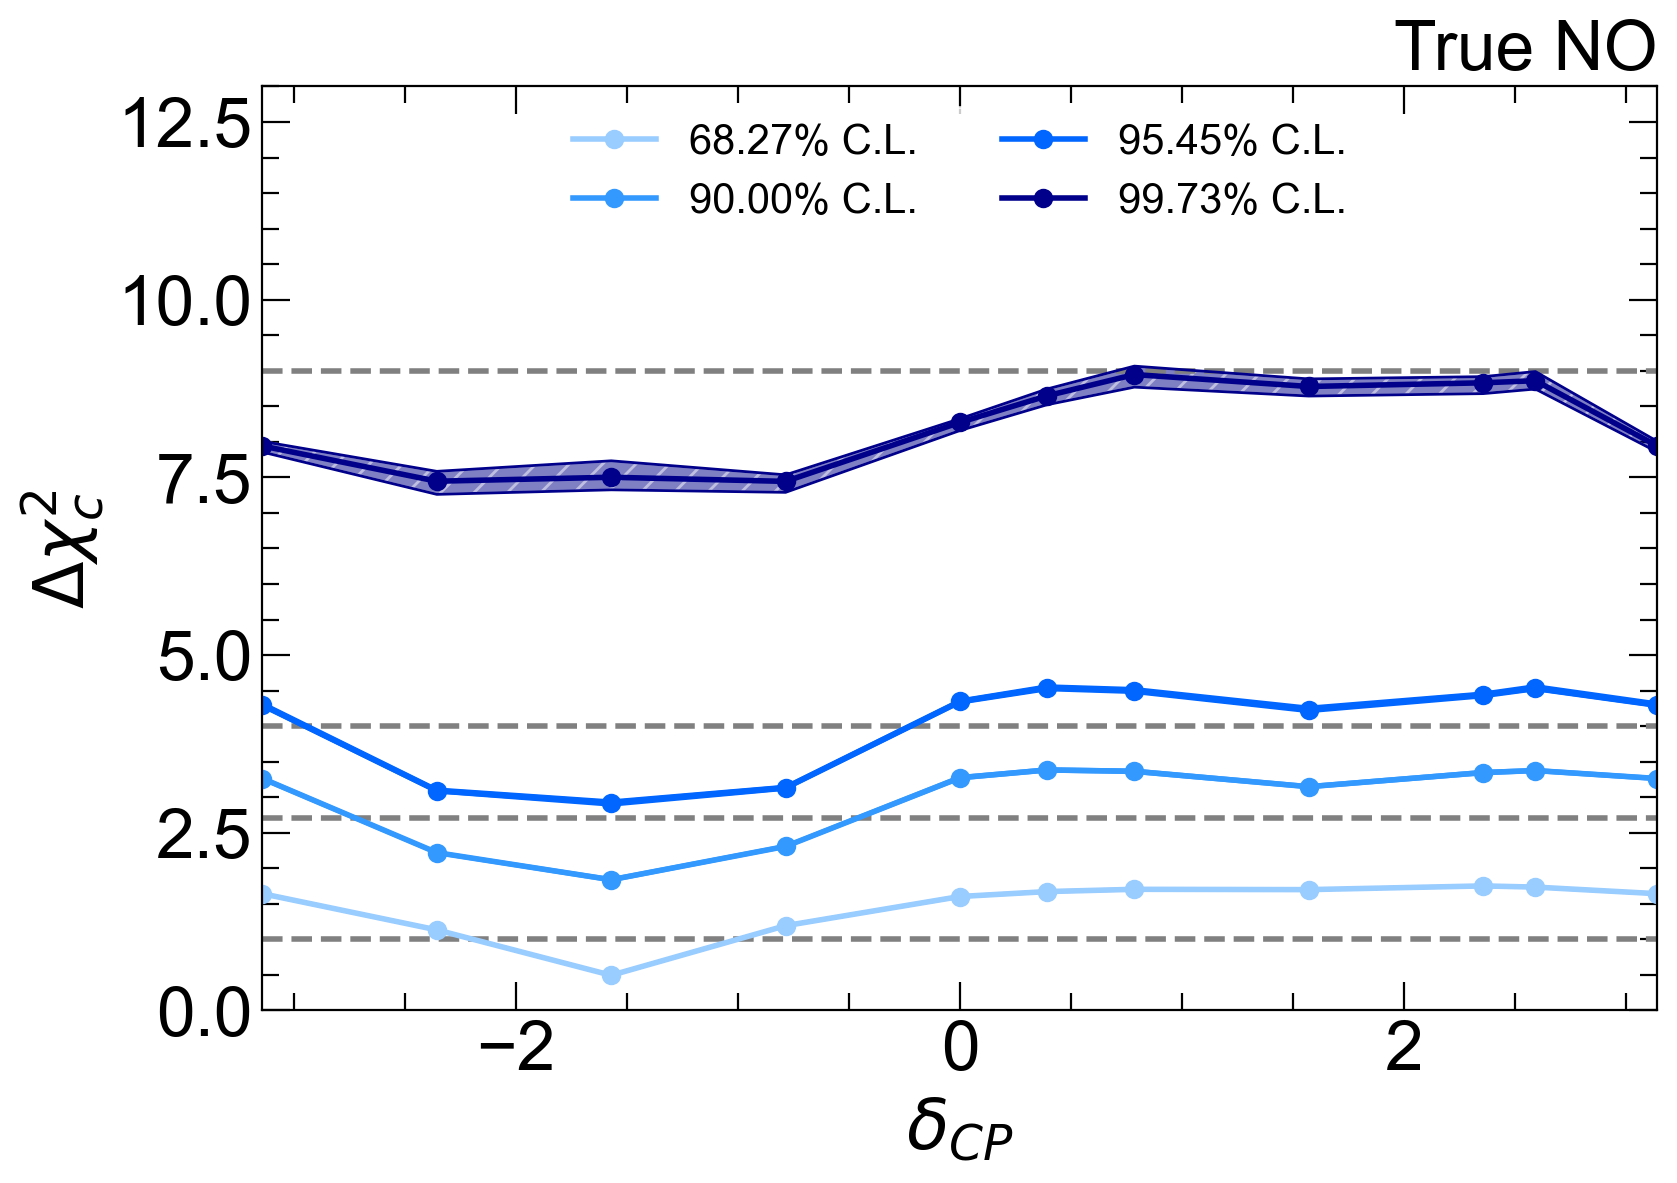

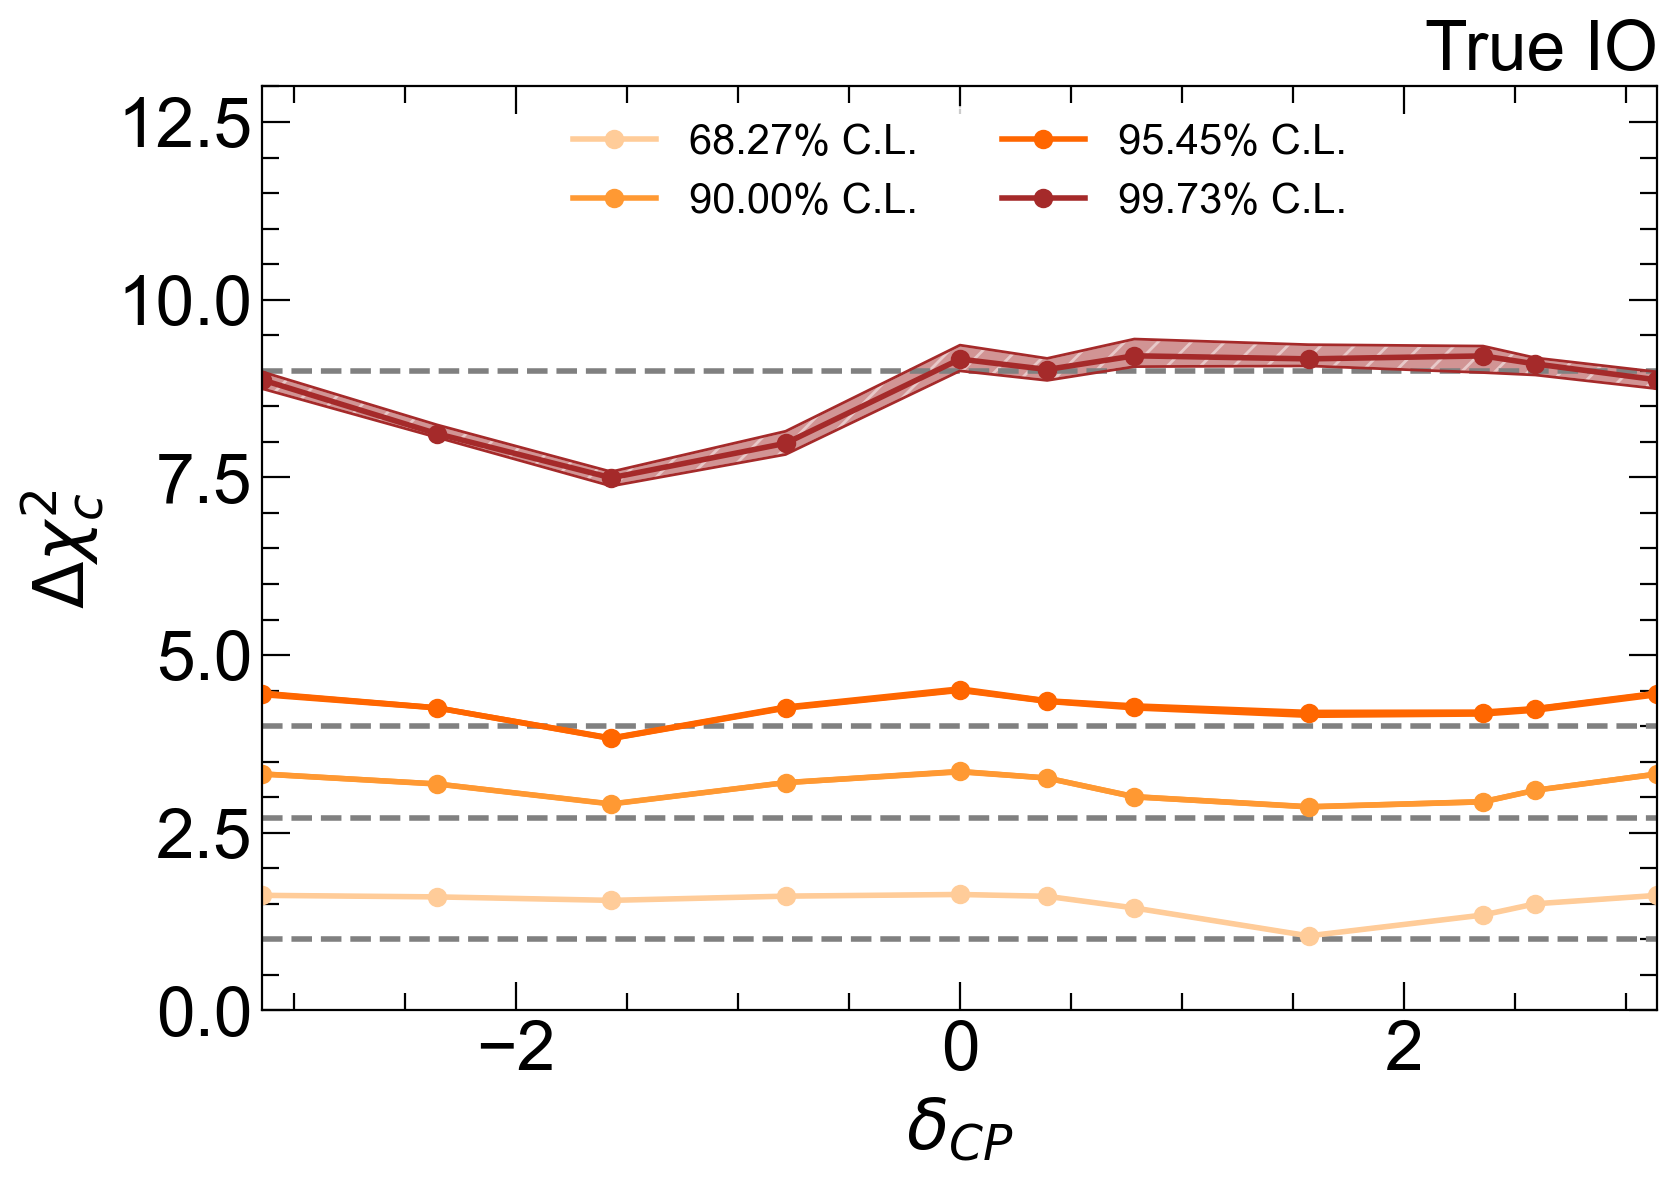

In [15]:
for true_mh in [0, 1]:
    fig, ax = plt.subplots()
    plot_crit_val(ax, param_name, true_param_grid_sorted[param_name], true_mh)
    ax.set_title(f'True {mo_to_title[true_mh]}', loc='right')
    ax.set_ylim(0, 13)
    fig.savefig(f'{outputs_dir}/plots/{dir_ver}/FC/FC_critical_values_{param_name_x}_truemh{true_mh}.pdf', bbox_inches='tight')